# COMP 6321 Assignment 1: Predictive Compression

This assignment asks you to do text compression using machine learning. Specifically, you're going to train machine learning models to predict "the next symbol" in a string and, by making "the next symbol" more predictable, you will make the string easier to compress. Like most real-world problems, a lot of the work is in understanding the problem setup.

To understand the idea, ask yourself: if you were given 5 symbols, `impor`, what would you guess for the *next symbol*? If those 5 symbols are enough to predict that the next symbol is a `t`, then there's no need to actually store the code for `t`! 

<img src="img/shannon.png" style="float:left; margin-right:8px"/>

In fact, [Claude Shannon](https://en.wikipedia.org/wiki/Claude_Shannon#/media/File:ClaudeShannon_MFO3807.jpg), the developer of information entropy, performed this exact experiment by asking his human colleagues to "guess the next letter" from context. Read page 1 of Peter Fenwick's [*Symbol Ranking Text Compression with Shannon Recodings*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.50.4148&rep=rep1&type=pdf). Question 3 of this assignment will ask you to implement compression using Shannon's "second method" (symbol rank encoding), where the classifier you trained in Question 2 plays the role of the "guesser". The better the guess, the more compressible the ranks are.

To understand how symbol rank encoding works, **consider a toy example**. Assume the symbol alphabet is $\{a,b,c\}$, for simplicity. A "guesser" receives one "previous symbol" and must guess a probabily for each possible "next symbol." The example guesser shown below (at left) believes that strings like `abcabc` are most probable whereas strings like `aaaaaa` or `bbbbbb` are improbable. The steps below depict how these probabilities are used to rank-encode the example string `[a,b,c,b,c]` as sequence of numbers `[0,0,0,1,0]`.

<img src="img/rank-encoding-1.png" width=750px/>

Notice that, in the rank encoding, the first `b` was encoded as 0, but the second `b` was encoded as 1 because the toy guesser expected `a` to be more probable, based on the previous symbol (i.e., the context).

When symbols are predicted correctly (or approximately-correctly), a rank-encoding is more compressible by a Huffman encoder because the new representation (rank ordinals) has lower information entropy than the original (ASCII ordinals)!

<img src="img/rank-encoding-2.png" width=520px/>

---

The assignment is very much like a lab, in that many steps build on each other. The main differences are:
1. the assignment combines multiple machine learning concepts, rather than one theme;
2. the assignment becomes more open-ended as questions progress, with fewer "guardrails";
3. the assignment will be more carefully graded, including code quality; and
4. where <span style="color:#080;font-weight:bold">specified</span>, you must add comments to your code.

The goal of the assignment is to exposes you to:
* Building a machine learning system for a real practical purpose (compression).
* Designing custom scikit-learn data transformers (converting dicts &amp; strings to features) and all the software engineering challenges there,
* Doing model selection over a pipeline with configurable stages (hyperparameter search).
* Using a loss function (classification performance) that differs from the ultimate measure of success (compression ratio).

**Grading.** There are 5 questions: Q1 (20 marks), Q2 (30 marks), Q3 (25 marks), Q4 (30 marks), Q5 (5 BONUS marks).

**Rules for academic integrity:**
* Like labs, students are encouraged to ask conceptual questions of TAs and of other students, and can answer each others' *conceptual* questions.
* Unlike labs, students are *not* allowed to post example code in a public forum, even if the code is wrong; code and pseudocode can only be shared with TAs when requesting help.
* Never ask for, or offer, code snippets for the assignment to your fellow students. Doing so is forbidden, and is a major violation of academic integrity, both of the person who shared the code and the person who accepted the code. Violations of academic integrity will be reported to the Dean's Office. Violators risk their academic standing.
* *Never* post your assignment on the internet, including Github, even after the course completes; see above rule.

**Read the statement below and insert your name:**

I, Pooya Khoshabi, hereby confirm that I have understood and at all times adhered to the above rules of academic integrity, and to the academic code of conduct at Concordia University. All completed steps of this submitted assignment are my own independent work.

**Advice:**
* *Invest in plotting.* Plotting is super important for ML and for data sciences generally. So, put in the time to learn how to make plots properly.
* *Set random_state whenever applicable.* Some steps of the assignment involve randomness, usually when calling scikit-learn functions. In order to make your assignment reproducible, you must set the *random_state* to some constant (e.g. 0) whenever applicable.
* *Save your notebook frequently.* Although Jupyter notebooks are mostly reliable, it is possible to encounter an erroneous state, where the most recent changes cannot be saved to disk by the notebook's own save functionality.

**Run the code cell below** to import the necessary packages.

In [1]:
!pip install scikit-learn==0.23.0

     |████████████████████████████████| 7.3MB 11.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.pipeline
import sklearn.feature_selection
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.utils
import sklearn.utils.estimator_checks
import zipfile 
import urllib
import requests
import sys

# Download huffman.py from github before importing
urllib.request.urlretrieve('https://raw.githubusercontent.com/soxofaan/dahuffman/' +
                           '7bbc964cee6947545ee4dfb4456c96c9be44cebc/dahuffman/' +
                           'huffmancodec.py', 'huffman.py')
import huffman

# Matplotlib might complain if lots of figures are generated; suppress that warning.
plt.rcParams.update({'figure.max_open_warning': 0})

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q1 &mdash; Download and compress text files [20 marks total]

This question asks you to download some example Python source code, and then compress it using a Python implementation of Huffman encoding. The specific source code you'll compress will be from scikit-learn's Github repository.

The reason to download a copy of scikit-learn's source code is *not* to install or to run it. In fact, you do not even need to extract the zip file. The *only* reason for downloading it to have some example Python source code.

Later on in the assignment, you will try to improve the compression using machine learning. In other words, you will be using your already-installed scikit-learn package to compress the separate scikit-learn source code that you just downloaded!

<div style="border-bottom: 1px solid black;"></div>

### *Q1a &mdash; Download Python code to use for training and testing [10 marks]*

**Download some example Python source code.** Specifically, download the source code to scikit-learn version 0.24.1 as a zip file. To do this, visit the scikit-learn github repository, find the tag `0.24.1`, click "browse files" and find the URL for `0.24.1.zip`.

You should do the download *procedurally*, by writing code in the code cell below, so that any time your notebook is run it will automatically download the correct data.

In [3]:
# Your code here.
url = 'https://github.com/scikit-learn/scikit-learn/archive/0.24.1.zip' 
urllib.request.urlretrieve (url, '0.24.1.zip')


('0.24.1.zip', <http.client.HTTPMessage at 0x7f96ae933550>)

**Implement *read_textfiles***. Use the *zipfile* package that is built in to Python.

In [4]:
def read_textfiles(zip_file: str, name_filter, maxbytes=None):
    """
    Open a zip file and returns two lists:
      names: list of file names for which name_filter(name) returned True
      texts: list of bytes objects with corresponding file contents.
    If maxbytes is specified, only the first maxbytes of each file will be read.
    """
    # Your implementation here.
    from zipfile import ZipFile
    file_name = zip_file
    with ZipFile(file_name, 'r') as zip:
        path_name = zip.namelist()
        names = []
        texts = []
        for i in path_name:
            if i.endswith(name_filter):
                names.append(i)
                if maxbytes != None:
                    texts.append(zip.read(i)[:maxbytes])
                else:
                    texts.append(zip.read(i))
    return names, texts         
        

**Load a training and test set.** Create two global variables, each referring to what we'll call a "text list" (a list of *bytes* objects). One variable should refer to a list of *bytes* objects containing source code from training files, and likewise the other should refer to data from testing files.
* training set is the three files ending with `/kernels.py`, `/_logistic.py`, and `/_gaussian_mixture.py`
* testing set is the two file ending with `/_ridge.py` and `/naive_bayes.py`

To keep reasonably training fast, load only the first 10,000 bytes of each file.

In [5]:
# Your code here
train = []
test = []
for i in ['/kernels.py', '/_logistic.py', '/_gaussian_mixture.py']:
    train.append(read_textfiles(zip_file = '0.24.1.zip', name_filter= i, maxbytes=10000)[1][0])
for i in ['/_ridge.py', '/naive_bayes.py']:
    test.append(read_textfiles(zip_file = '0.24.1.zip', name_filter= i, maxbytes=10000)[1][0])

**Implement *preview_textlist*** and **run it on your training and test sets** so that you and the TA can see excerpts of your data.

In [6]:
def check_is_textlist(x):
    if not isinstance(x, list) or \
       not all(isinstance(text, bytes) for text in x):
        raise ValueError("Expected textlist")

def preview_textlist(x: list, maxitems=5, maxbytes=100):
    """
    Prints some example excerpts from the entries of x.    
    Up to maxitems entries are shown, and for each up to
    maxbytes are printed in the preview.
    
    For example:
       >>> x = [b'good', b'luck on', b'the assignment']
       >>> preview_textlist(x, maxfiles=2, maxbytes=4)
       Contains 3 file(s) totalling 25 bytes:
       
       b'good'

       b'luck'
    """
    check_is_textlist(x)
    # Your implementation here
    number_bytes = 0
    for i in x:
        number_bytes += len(i)
    print('contains %d files totaly %d bytes: \n' %(len(x), number_bytes))
    for i in x[:maxitems]:
        print (i[:maxbytes], '\n')

# Call your implementation here
preview_textlist(x= test, maxitems=2, maxbytes=10)

contains 2 files totaly 20000 bytes: 

b'"""\nRidge ' 

b'# -*- codi' 



**Define a complete alphabet.** When training on categorical features or targets, whether they be ASCII symbols like $\{a,b,c\}$ or job titles like $\{teacher,police,doctor\}$, it is important to not assume that your training set contains all the symbols (categories) for which you need to make predictions. Why? Because training sets are often split up in arbitrary ways, such as for cross-validation; if one of those chunks is missing a category that you need to make predictions from, then it will cause your ML system to raise annoying errors at test time or at cross-validation time, often after lots of CPU time invested. So, use the code cell below to define an *ALPHABET* global variable for later use.

Ensure *ALPHABET*'s symbols appear in order of increasing ordinal value. Explicitly add the NULL byte with ordinal value 0 (`\x00`), since it will be used to mean "no symbol" later on. Print *ALPHABET*'s length and contents, like below but with `?` replaced with values:
```
??? symbols
b'\x00??????????????????????....'
```

In [7]:
# Your code here
ALPHABET = b'\x00\n' + bytes(range(32,127))
print(len(ALPHABET), 'symbols')
print(ALPHABET)

97 symbols
b'\x00\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~'


In [8]:
#ALPHABET = b'\0'+b'\n'+b' '+b'!'+b'"'+b'#'+b'%'+b"'"+b'('+b')'+b'*'+b'+'+b','+b'-'+b'.'+b'/'+b'0'+b'1'+b'2'+b'3'+b'4'+b"5"+b'6'+b'7'+b'8'+b'9'+b':'+b';'+b'<'+b'='+b'>'+b'@'+b'A'+b'B'+b'C'+b'D'+b'E'+b'F'+b'G'+b'H'+b'I'+b'J'+b'K'+b'L'+b'M'+b'N'+b'O'+b'P'+b'R'+b'S'+b'T'+b'U'+b'V'+b'W'+b'X'+b'Y'+b'['+b'\x5C' +b']'+b'^'+b'_'+b'`'+b'a'+b'b'+b'c'+b'd'+b'e'+b'f'+b'g'+b'h'+b'i'+b'j'+b'k'+b'l'+b'm'+b'n'+b'o'+b'p'+b'q'+b'r'+b's'+b't'+b'u'+b'v'+b'w'+b'x'+b'y'+b'z'+b'{'+b'|'+b'}'+b'~'

<div style="border-bottom: 1px solid black;"></div>

### *Q1b &mdash; Define a scikit-learn Transformer to compress text files [10 marks]*

**Define a *HuffmanEncoder* transformer class.** Define a custom scikit-learn transformer, so that the following code would run:
```python
>>> x = [b'aaaa', b'bbb']
>>> huff = HuffmanEncoder()
>>> huff.fit(x).transform(x)   # Success!
[b'\n', b'\xfe']
>>> huff.fit_transform(x)      # Same, provided by TransformerMixin!
[b'\n', b'\xfe']
>>> z = [b'c']                 # New text not in training set
>>> huff.transform(z)          # Uh-oh, unrecognized symbol 'c' (ord 99)
KeyError: 99
>>> HuffmanEncoder(alphabet=b'abc').fit(x).transform(z)  # Force 'c' into alphabet
[b'\x94']

```
And as for all steps in this assignment it's important to do basic sanity checks of arguments:
```python
>>> huff = HuffmanEncoder()
>>> huff.transform(x)          # Checks that fit() has been called
NotFittedError: This HuffmanEncoder instance is not fitted yet.
>>> huff.fit(x, y=[1,2,3])     # Checks that y arg not used
ValueError: Expected None
>>> huff.fit(b'abc')           # Checks that x is a textlist
ValueError: Expected textlist

```

To do this correctly, you're going to want to:
1. Look at the *a1-intro.ipynb* notebook and learn how the downloaded *huffman* Python module could help make your class very easy to implement. All the pieces you need are there, including "dealing with unrecognized symbols."
2. Look at examples of how other scikit-learn transformers have been implemented, such as the [source code for *StandardScaler*](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/preprocessing/_data.py#L564), and understand why it inherits both [*BaseEstimator*](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [*TransformerMixin*](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html). 
3. Understand scikit-learn conventions around "[estimated attributes](https://scikit-learn.org/stable/developers/develop.html#estimated-attributes)" to signify that *fit* has been called, the meaning of "trailing underscores", the fact that estimator attributes are "cloned" from the original prototype argument before *fit* (important for making hyperparameter search work), and how [*check_is_fitted*](https://scikit-learn.org/stable/modules/generated/sklearn.utils.validation.check_is_fitted.html) automatically raises *NotFittedError* for you.

The documentation on [developing scikit-learn estimators](https://scikit-learn.org/stable/developers/develop.html) may also help, although it discusses many features you do not need for this particular exercise. Your *HuffmanEncode* class transforms a *list* object to a new *list* object, rather than an $\mathbf{X}$ matrix. As such, it will not pass the checks by *sklearn.utils.estimator_checks.check_estimator*, but that is OK! 

<span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [9]:
def check_is_none(y):
    if y is not None:
        raise ValueError("Expected None")
            
urllib.request.urlretrieve('https://raw.githubusercontent.com/soxofaan/dahuffman/' +
                           '7bbc964cee6947545ee4dfb4456c96c9be44cebc/dahuffman/' +
                           'huffmancodec.py', 'huffman.py')
import huffman
import sys        
        
from sklearn.base import BaseEstimator, TransformerMixin 
from collections import Counter
#from sklearn.utils.validation import check_is_fittedclass 

# Your class definition here. You can also import whatever you need.
class HuffmanEncoder(TransformerMixin, BaseEstimator):


    
    def __init__(self, alphabet=b''):
        self.alphabet= alphabet
        self.encoded= None
        self.transformed_values= []
        self.decoded_values= []

    def check_fitted(self):
        sklearn.utils.validation.check_is_fitted(self)    
    
    def fit(self, x, y=None):
        check_is_none(y)
        check_is_textlist(x)
        
        
        words = b''
        for i in x:
            words = words + i 
        if self.alphabet == b'':
            self.encoded = huffman.HuffmanCodec.from_data(words)
        else:
            freqs_data = Counter(words)
            freqs_min = Counter({c: 1e-6 for c in self.alphabet})
            freqs = freqs_data | freqs_min
            self.encoded = huffman.HuffmanCodec.from_frequencies(freqs, concat=bytes)
        
        self.alphabet_ = self.alphabet #just wanted to satisfy the check_fitted method while compiling.    
        
        return self
    
    def transform(self, x, y=None):
        self.check_fitted()
        check_is_textlist(x)
        
        self.transformed_values = []
        
        
        try:
            for j in x:
                self.transformed_values.append(self.encoded.encode(j))
        except KeyError as e:
                print("KeyError:", e)
                
        return self.transformed_values   
    
    def score(self, x, y=0):
        fit = self.fit_transform(x)
        uncompressed = sum(len(i) for i in x) 
        compressed   = sum(len(j) for j in fit) 
        #print('uncompressed: ', uncompressed)
        #print('compressed: ', compressed)
        return uncompressed/compressed
    
    def inverse_transform(self, x, y=None):
        for i in x:
            self.decoded_values.append(self.encoded.decode(i))
        return self.decoded_values 
        

**Preview Huffman-encoded versions of your datasets.** The output should be similar to your earlier preview, except the total bytes should be smaller and the data should mostly be non-printable byte codes.

In [10]:
# Your code here
#================================================================
#part1
x = [b'aaaa', b'bbb']
z = [b'c'] 
huff = HuffmanEncoder()
compressed1 = huff.fit(x).transform(x) 
compressed2 = huff.fit_transform(x)
#compressed3 = huff.transform(z) #contains error
compressed4 = HuffmanEncoder(alphabet=b'abc').fit(x).transform(z)

print('compressed1:' ,compressed1)
print('compressed2:' ,compressed2)
#print('compressed3:' ,compressed3) 
print('compressed4:' ,compressed4)
#================================================================
#part2
#huff = HuffmanEncoder()   
#huff.transform(x)         #contains error
#huff.fit(x, y=[1,2,3])    #contains error             
#huff.fit(b'abc')          #contains error 



compressed1: [b'\xf0', b'T']
compressed2: [b'\xf0', b'T']
compressed4: [b'\x94']


**Implement a *score* method** on your *HuffmanEncode* class definition. Do so by editing the earlier code cell. A *HuffmanEncode* object should score a text list by returning the [compression ratio](https://en.wikipedia.org/wiki/Data_compression_ratio) achieved. For example:
```python
>>> huff.score(x)   # If hypothetically a 3.5x compression ratio
3.5
```
In the code cell below, print the compression ratio of your training and (separately) testing sets.

In [11]:
# Print the compression ratios of your training and testing sets here
huff = HuffmanEncoder()
huff.fit(train).transform(train) 
print('train compression ratio: ', huff.score(train))

huff.fit(test).transform(test)
print('test compression ratio: ',huff.score(test))

train compression ratio:  1.7361111111111112
test compression ratio:  1.734304543877905


**Implement an *inverse_transform* method** on your *HuffmanEncode* class definition in the earlier code cell. Just like for other scikit-learn transformers, this should "undo" the transformation (i.e., decompress a compressed textlist). Once you have added that function, use it in the code cell below to **assert that it decompresses your training and (separately) testing data correctly.**

In [12]:
# Your assertions here
huff = HuffmanEncoder()
compressed = huff.fit(x).transform(x) 
huff.inverse_transform(compressed)

[b'aaaa', b'bbb']

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q2 &mdash; Extract features and train a model [30 marks total]

This question is a simplified version of the core learning task of the assignent. Specifically, you'll extract features and train a "next symbol predictor", but in a way that only requires small, easy, isolated steps, without any fancy software engineering.

<div style="border-bottom: 1px solid black;"></div>

### *Q2a &mdash; Extract symbol context features [10 marks]*

**Implement *extract_text_context*.** For example:
```python
>>> extract_text_context(b'ABCDEFG', 3)
array([[b'', b'', b''],
       [b'', b'', b'A'],
       [b'', b'A', b'B'],
       [b'A', b'B', b'C'],
       [b'B', b'C', b'D'],
       [b'C', b'D', b'E'],
       [b'D', b'E', b'F']], dtype='|S1')
```
Use Numpy effectively in your answer.

In [13]:
def extract_text_context(text: bytes, size):
    """
    Returns an array X representing the ASCII symbol context
    that preceeded each byte position of byte string 'text'.
    
    Specifically, row X[i,:] contains the 'size' symbols that
    preceeded the symbol text[i]. If no such symbol existed,
    (too close to start) a NULL byte (0) is used in its place.
    """
    # Your implementation here
    buffer = np.frombuffer(text, dtype='|S1')
    X = np.full((len(text),size), b'')
    
    for i in range(len(text)):
        for j in range(size):
            if i<size:
                if i+j <size:
                    X[i,j] = b''   
                else:
                    X[i,j] = buffer[i+j-size]
            else:
                X[i,:] = np.frombuffer(text, dtype='|S1', count=size, offset=i-size)  
    return X           

extract_text_context(b'ABCDEFG', 3)

array([[b'', b'', b''],
       [b'', b'', b'A'],
       [b'', b'A', b'B'],
       [b'A', b'B', b'C'],
       [b'B', b'C', b'D'],
       [b'C', b'D', b'E'],
       [b'D', b'E', b'F']], dtype='|S1')

**Implement *extract_context*.** This will be useful for converting a list of *bytes* objects into a feature matrix. For example:
```python
>>> extract_context([b'ABCD', b'EFG'], 3)
array([[b'', b'', b''],
       [b'', b'', b'A'],
       [b'', b'A', b'B'],
       [b'A', b'B', b'C'],
       [b'', b'', b''],
       [b'', b'', b'E'],
       [b'', b'E', b'F']], dtype='|S1')
```

In [14]:
def extract_context(x: list, *args, **kwargs):
    """
    Returns a concatenation of all context features extracted
    from every text string in the given filedict, in the order
    that the text entries appear. Any extra arguments are
    forwarded to extract_text_context.
    """
    # Your implementation here

    list_of_features = None
    for i in x:
        temp = extract_text_context(i, *args, **kwargs)

        if list_of_features is None:
          list_of_features = extract_text_context(i, *args, **kwargs)

        else:
          list_of_features = np.concatenate((list_of_features, temp), axis=0)  
    
    return list_of_features
    

extract_context([b'ABCD', b'EFG'], 3)

array([[b'', b'', b''],
       [b'', b'', b'A'],
       [b'', b'A', b'B'],
       [b'A', b'B', b'C'],
       [b'', b'', b''],
       [b'', b'', b'E'],
       [b'', b'E', b'F']], dtype='|S1')

**Implement *make_sklearn_dataset*.** This function is just a convenient way to get not just the context features $\mathbf{X}$ but also corresponding targets $\mathbf{y}$ for scikit-learn style training or testing.
```python
>>> X, y = make_sklearn_dataset([b'ABCD', b'EFG'], 3)
>>> X
array([[b'', b'', b''],
       [b'', b'', b'A'],
       [b'', b'A', b'B'],
       [b'A', b'B', b'C'],
       [b'', b'', b''],
       [b'', b'', b'E'],
       [b'', b'E', b'F']], dtype='|S1')
>>> y
array([b'A', b'B', b'C', b'D', b'E', b'F', b'G'], dtype='|S1')
```

In [15]:
def make_sklearn_dataset(x: list, *args, **kwargs):
    """    
    Converts a list of bytes objects into arrays X and y suitable
    for use as a dataset with a scikit-learn estimator.
    """
    # Your implementation here.
    X = extract_context(x, *args, **kwargs)
    
    buffer = b''
    for i in x:
        buffer = buffer + i
    y = np.frombuffer(buffer, dtype='|S1')
    
    return X , y
make_sklearn_dataset([b'ABCD', b'EFG'], 3)

(array([[b'', b'', b''],
        [b'', b'', b'A'],
        [b'', b'A', b'B'],
        [b'A', b'B', b'C'],
        [b'', b'', b''],
        [b'', b'', b'E'],
        [b'', b'E', b'F']], dtype='|S1'),
 array([b'A', b'B', b'C', b'D', b'E', b'F', b'G'], dtype='|S1'))

**Convert your training and test sets to arrays.** Use your *make_sklearn_dataset* function to build training and testing arrays. Each feature vector should contain the 5 ASCII symbols preceeding each corresponding target. In future steps we may refer to these arrays as $(\mathbf{X}_\text{trn}, \mathbf{y}_\text{trn})$ and $(\mathbf{X}_\text{tst}, \mathbf{y}_\text{tst})$. Your code cell should also **print the first 10 rows of your $\mathbf{X}_\text{trn}$ and $\mathbf{y}_\text{trn}$ arrays, then $\mathbf{X}_\text{tst}$ and $\mathbf{y}_\text{tst}$ arrays**, so that the TA can see your raw symbol features.

In [16]:
# Your code here
Xtrn, ytrn = make_sklearn_dataset(train, 5)
Xtst, ytst = make_sklearn_dataset(test, 5)
print('Xtrn is:\n' , Xtrn[0:10, :])
print('ytrn is:\n' , ytrn)
print('Xtst is:\n' , Xtst[0:10, :])
print('ytst is:\n' , ytst)

Xtrn is:
 [[b'' b'' b'' b'' b'']
 [b'' b'' b'' b'' b'"']
 [b'' b'' b'' b'"' b'"']
 [b'' b'' b'"' b'"' b'"']
 [b'' b'"' b'"' b'"' b'K']
 [b'"' b'"' b'"' b'K' b'e']
 [b'"' b'"' b'K' b'e' b'r']
 [b'"' b'K' b'e' b'r' b'n']
 [b'K' b'e' b'r' b'n' b'e']
 [b'e' b'r' b'n' b'e' b'l']]
ytrn is:
 [b'"' b'"' b'"' ... b'v' b'a' b'r']
Xtst is:
 [[b'' b'' b'' b'' b'']
 [b'' b'' b'' b'' b'"']
 [b'' b'' b'' b'"' b'"']
 [b'' b'' b'"' b'"' b'"']
 [b'' b'"' b'"' b'"' b'\n']
 [b'"' b'"' b'"' b'\n' b'R']
 [b'"' b'"' b'\n' b'R' b'i']
 [b'"' b'\n' b'R' b'i' b'd']
 [b'\n' b'R' b'i' b'd' b'g']
 [b'R' b'i' b'd' b'g' b'e']]
ytst is:
 [b'"' b'"' b'"' ... b' ' b' ' b' ']


<div style="border-bottom: 1px solid black;"></div>

### *Q2b &mdash; Train a DummyClassifier to predict symbol probabilities  [10 marks]*

**Train a *DummyClassifier* on your $\mathbf{X}_\text{trn}$ and $\mathbf{y}_\text{trn}$ arrays.** Your code should:
* Set the *strategy* argument to ensure *predict_proba* counts the frequency of each symbol in target vector $\mathbf{y}_\text{trn}$.
* Force the *DummyClassifier* to output probabilities for every symbol in *ALPHABET*, not just those appearing in $\mathbf{y}_\text{trn}$.

Your code cell should print the training and testing accuracy, and the *DummyClassifier*'s number of output classes, as in:
```
accuracy: trn=0.?????? tst=0.??????
nclasses: ?
```

In [17]:
def add_alphabet(X, y, alphabet: bytes):
    """
    Modify a training set so as to force a scikit-learn classifier
    to be capable of outputting every symbol in the given alphabet,
    even if those symbols did not appear in 'y'.
    
    For example:
       >>> X_, y_, w_ = add_alphabet(X, y, b'abc')
       >>> classifier.fit(X_, y_, sample_weight=w_)
    """
    if alphabet is None:
        return X, y, None
    n, m = X.shape[0], len(alphabet)
    X_ = X[np.maximum(0, np.arange(-m, n))]  # Works for sparse or dense
    y_ = np.concatenate([np.frombuffer(alphabet, 'S1'), y])
    w_ = np.concatenate([np.full(m, 1e-100), np.ones(n)])  # 1e-100 rather than 0.0; see https://github.com/scikit-learn/scikit-learn/issues/19654
    return X_, y_, w_


In [18]:
# Your code here
X_train, y_train, w_train = add_alphabet(Xtrn, ytrn, ALPHABET)
clf = sklearn.dummy.DummyClassifier(strategy='prior', random_state=0)
clf.fit(X_train, y_train, sample_weight = w_train)
train_accuracy  = sklearn.metrics.accuracy_score(y_train, clf.predict(X_train))
test_accuracy   = sklearn.metrics.accuracy_score(ytst, clf.predict(Xtst))
n_classes       = clf.n_classes_


print("accuracy: trn= %.3f tst=%.3f" %(test_accuracy, train_accuracy))
print("nclasses: %d" %(n_classes))

accuracy: trn= 0.260 tst=0.238
nclasses: 97


**Print an example of the *DummyClassifier*'s predictions.** Specifically, print the first 10 training targets in $\mathbf{y}_\text{trn}$ alongside the *DummyClassifier*'s predicted symbol. You should convert targets and predictions to *bytes*, so that the output is formatted like:
```
targets: b'??????????'
predict: b'??????????'
```
where each `?` is replaced by a symbol.

In [19]:
# Your code here
target  = b''
predict = b''
for i in y_train[0+97:20+97]             : target  = target+i
for i in clf.predict(X_train[0+97:20+97]): predict = predict+i
print('target: ', target)
print('predict:', predict)

target:  b'"""Kernels for Gauss'
predict: b'                    '


**Run the code cell below** to define a helpful function for printing symbols like `a` instead of `b'a'`. Just for readability!

In [20]:
def as_printable(text: bytes):
    """
    Converts each byte into a string suitable for printing and plots,
    where most non-printable characters are converted to number strings.

    For example:
       >>> as_printable(b'ab \n\xa9')  # a, b, space, newline (10), copyright (169)
       ['a', 'b', ' ', '\\n', '©']
    """
    assert isinstance(text, bytes), "Expected bytes object"
    return [chr(c) if chr(c).isprintable() else '\\n' if c == 10 else '\\'+str(c) for c in text]

as_printable(b'ab \n\xa9')

['a', 'b', ' ', '\\n', '©']

**Print the *DummyClassifier*'s symbols and frequencies.** Figure out which attribute of your trained *DummyClassifier* are helpful here. Your cell output should look something like below with the `?` values filled in:
```
rank  frequency symbol
0     0.??????  ?  
1     0.??????  ?
2     0.??????  ?
...
?     0.??????  ?
```
You can apply *as_printable* to the symbols if you like to make the printing nicer, but you do not have to.

In [21]:
# Your code here.
rank      = np.arange(0, n_classes)
frequency = clf.class_prior_
symbol    = clf.classes_  

Dict = {}
for i in range(0, len(rank)):
    Dict[symbol[i]] = frequency[i]
    
Dict_sorted = {key: value for key, value in sorted(Dict.items(), key=lambda item: item[1], reverse=1)}

general_dict = {}
j= 0
for i in Dict_sorted:
    general_dict[rank[j]] = [Dict_sorted[i],i]
    j = j+1
    
print ("{:<8} {:<25} {:<10} ".format('rank','freq','symbol'))
for k, v in general_dict.items():
    freq, symbol  = v
    print ("{:<8} {:<25} {:<10} ".format(k, freq, symbol))


rank     freq                      symbol     
0        0.2385                    b' '       
1        0.07663333333333333       b'e'       
2        0.056                     b'a'       
3        0.0495                    b's'       
4        0.04613333333333333       b'r'       
5        0.045                     b't'       
6        0.040933333333333335      b'n'       
7        0.0373                    b'i'       
8        0.034333333333333334      b'o'       
9        0.030166666666666668      b'\n'      
10       0.026766666666666668      b'p'       
11       0.023666666666666666      b'l'       
12       0.022                     b'c'       
13       0.020733333333333333      b'm'       
14       0.019233333333333335      b'_'       
15       0.017433333333333332      b'h'       
16       0.0172                    b'f'       
17       0.015366666666666667      b'u'       
18       0.014833333333333334      b'd'       
19       0.014333333333333333      b'.'       
20       0.01

**Implement *plot_symbol_probs.*** This function visualizes the "next symbol" probabilities (the class probabilities) and the corresponding true symbols (the targets). When applied to your *DummyClassifier* and training set, your plot should look something like the one below. You will use this plotting function to visualize probabilities and predictions:
<img src="img/symbol-probs-dummy.png"/>
*Hint:* Try using `colorbar(fraction=0.01, pad=0.01)` or similar to shrink the colorbar.

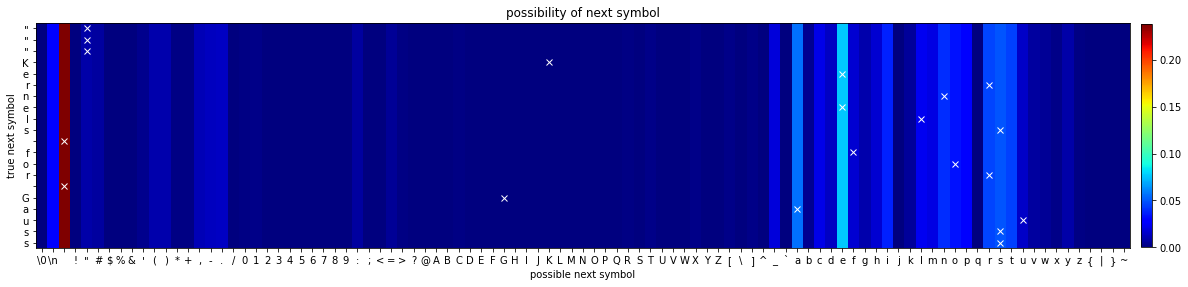

In [23]:
def plot_symbol_probs(estimator, X, y, rows=20):
    
    """
    Plots a heatmap where each row shows two things:
      1. a target symbol (shown as y-axis label, and by a white 'x'
         in the column corresponding to that symbol)
      2. the estimator's class probabilities when trying to predict
         that symbol from context X (classes shown on x-axis labels).
    The max number of rows (true next symbols) shown is given by 'rows'.
    """
    
    assert sklearn.base.is_classifier(estimator)
    # Your implementation here
    
    probability = np.zeros((rows,estimator.n_classes_))
    for i in range(rows):
        probability[i] = estimator.predict_proba(X)[i]

    plt.figure(figsize=(20,5)) 
    for i in range(len(ALPHABET)):
        for j in range(len(y[0:rows])):
            if np.frombuffer(ALPHABET, dtype='S1')[i] == y[j]:
                plt.plot(i, j, marker='x', color='w') 
    color_map = plt.imshow(probability, origin='upper')
    plt.colorbar(fraction=0.01, pad=0.01)
    plt.title('possibility of next symbol')
    plt.xlabel('possible next symbol')
    plt.ylabel('true next symbol')
    plt.xticks(list(range(len(ALPHABET))), as_printable(ALPHABET))
    plt.yticks(list(range(rows)), as_printable(y.tobytes()[0:20]))
    color_map.set_cmap('jet')


# Call your implementation on your trained DummyClassifier here
plot_symbol_probs(clf, Xtrn, ytrn, rows=20)

**Question.** Complete the following sentence: "My *DummyClassifier* will correctly predict the 'next symbol' if..."

My DummyClassifier will correctly predict the 'next symbol' if it's space.

<div style="border-bottom: 1px solid black;"></div>

### *Q2c &mdash; Train a DecisionTreeClassifier to predict symbol probabilities [10 marks]*

Most scikit-learn estimators do not accept ASCII bytes (*dtype='S1'*) as input features. Instead, they expect *dtype=float64*. So, before training your *DecisionTreeClassifier*, you need a way to transform your ASCII feature matrix $\mathbf{X}_\text{trn}$ into some numerical representation compatible with scikit-learn estimators. Standard choices are *OrdinalEncoder* and *OneHotEncoder*.

**Train an OrdinalEncoder on your $\mathbf{X}_\text{trn}$ array.** Your encoder should be able to accept any extended ASCII symbol (any byte) in any feature column. Your code cell should also print the transformed version of the first 10 rows of $\mathbf{X}_\text{trn}$.

In [24]:
# Your code here
def convert_ascii(X):
    oe= sklearn.preprocessing.OrdinalEncoder(dtype= np.float64)
    X_= oe.fit(X).transform(X)

    return X_

print(convert_ascii(Xtrn)[0:9,:])
print(convert_ascii(X_train)[0:9,:])

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.]
 [ 0.  0.  0.  4.  4.]
 [ 0.  0.  4.  4.  4.]
 [ 0.  4.  4.  4. 39.]
 [ 4.  4.  4. 39. 62.]
 [ 4.  4. 39. 62. 75.]
 [ 4. 39. 62. 75. 71.]
 [39. 62. 75. 71. 62.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


**Train a *DecisionTreeClassifier*.** Use default hyperparameters (but always set *random_state*). Your code cell should print the training and testing accuracy:
```
accuracy: trn=0.?????? tst=0.??????
nclasses: ?
```

In [25]:
dt = sklearn.tree.DecisionTreeClassifier()
dt.fit(convert_ascii(X_train), y_train, sample_weight = w_train) 

train_accuracy  = sklearn.metrics.accuracy_score(y_train, dt.predict(convert_ascii(X_train)))
test_accuracy   = sklearn.metrics.accuracy_score(ytst, dt.predict(convert_ascii(Xtst)))
n_classes       = dt.n_classes_


print("accuracy: trn= %.6f tst=%.6f" %(train_accuracy, test_accuracy))
print("nclasses: %d" %(n_classes))

accuracy: trn= 0.877297 tst=0.300050
nclasses: 97


**Plot the predicted symbol probabilities.** Use your *plot_symbol_probs* function from earlier.

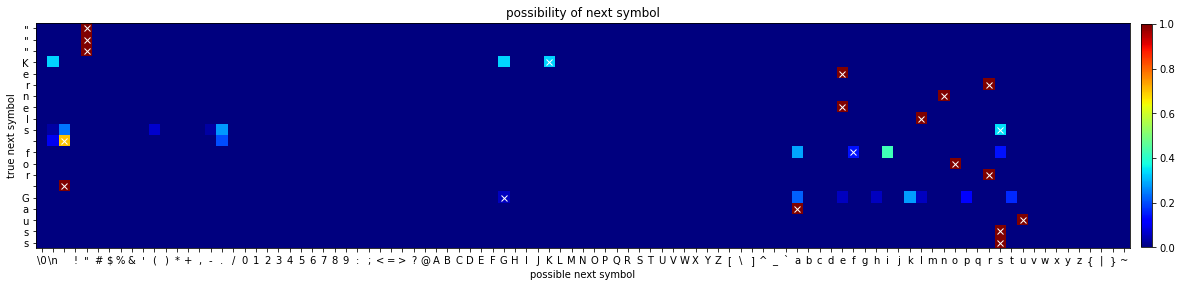

In [26]:
# Call your plotting function here
plot_symbol_probs(dt, convert_ascii(Xtrn), ytrn, rows=20)

The rows should now have different probabilities, and the "true next symbol" should be predicted correctly more often!

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q3 &mdash; Use predictions to compress text [25 marks total]

This question asks you to use your *DecisionTreeClassifier* from Question 2 to transform a symbol (e.g., `e` or `+`) into the "rank of that symbol's predicted probability" (e.g., 0 or 13). The idea is depicted visually at the top of this assignment.

The core part of this question will be to define a scikit-learn style trainable pipeline with two top-level steps:
1. Rank-encode the symbols using tools you built in Question 2:
   * extract context features (e.g., symbols like `['i', 'm', 'p', 'o', 'r']`)
   * convert features to numbers (e.g., ordinal encoding like `[73, 77, 80, 79, 82]`)
   * predict probability of each possible "next symbol" (e.g., like `'t'`) from the context features
2. Huffman-encode the ranks using your class from Question 1

<div style="border-bottom: 1px solid black;"></div>

### *Q3a &mdash; Transform symbols into their predicted rank [5 marks]*

**Implement *rankencode*.** 

```python
>>> y = np.frombuffer(b'abcbc', 'S1')   # Symbols to encode
>>> c = np.frombuffer(b'abc', 'S1')     # Symbol class for each column of p
>>> p = np.array([[.5, .2, .3],         # Predicted symbol probabilities
...               [.0, .7, .3],
...               [.3, .0, .7],
...               [.7, .3, .0],
...               [.3, .0, .7]])
>>> rankencode(y, c, p)                 # Convert each symbol to a rank
array([0, 0, 0, 1, 0], dtype=uint8)

>>> y = np.frombuffer(b'abcxyz', 'S1')  # Uh-oh, can't encode symbols 'xyz'!
>>> rankencode(y, c, p)
ValueError: Not all symbols in y were found in the classes c
>>> rankencode(y.astype('S4'), c, p)
ValueError: Dtypes of y and c must match
```
Only a few lines of vectorized code are needed. <span style="color:#080;font-weight:bold">Briefly comment each line of your code.</span>

In [27]:
def rankencode(y, c, p):
    """
    Returns a rank-encoded version of array y.

    y: length-N array to encode.
    c: length-M array of symbols in the alphabet.
    p: NxM array of probabilities where probs[i,j] is
       the probability that input symbol i is going
       to match alphabet element j; this is the same
       layout scikit-learn's predict_proba function.
    """
    # Your implementation here
    if c.dtype != y.dtype: # type match
        raise ValueError('Dtypes of y and c must match')
    rank = []
    for i in range(y.shape[0]):
        if y[i] not in c:
            raise ValueError('Not all symbols in y were found in the classes c') # existence match
        
        row = p[i] #each line of p in each iteration
        Dict = dict(zip(c,row)) #{b'a': 0.5, b'c': 0.3, b'b': 0.2} giving sth like this
        Dict_sorted = {key: value for key, value in sorted(Dict.items(), key=lambda item: item[1], reverse=1)}
        rank.append(list(Dict_sorted.keys()).index(y[i])) # find symbols rank in sorted list of probabilities
    return np.array(rank, 'uint8') # return rank as a numpy array

**Check your answer** by running the code cell below. It should reproduce the example from the top of this assignment, encoding *[a,b,c,b,c]* as *[0, 0, 0, 1, 0]*, along with some other sample strings that you can use to verify correctness.

In [28]:
class ToyGuesser:
    """Toy "guesser" from the top of the assignment as scikit-learn style class."""

    def __init__(self):
        self.classes_ = np.frombuffer(b'abc', 'S1')  # Mimick sklearn classes_ attribute
        
    def predict_proba(self, text: bytes):
        p = dict(zip(b'\0abc', [[.5, .2, .3], [.0, .7, .3], [.3, .0, .7], [.7, .3, .0]]))
        return np.array([p[c] for c in (b'\0' + text[:-1])])  # unvectorized for simplicity

toy = ToyGuesser()
for text in [b'abcbc', b'abcabc', b'cbaacba', b'aaa', b'bbb', b'ccc']:
    print(text.decode('ascii'), '->',
          rankencode(np.frombuffer(text, 'S1'), toy.classes_, toy.predict_proba(text)))

abcbc -> [0 0 0 1 0]
abcabc -> [0 0 0 0 0 0]
cbaacba -> [1 1 1 2 1 1 1]
aaa -> [0 2 2]
bbb -> [2 2 2]
ccc -> [1 2 2]


<div style="border-bottom: 1px solid black;"></div>

### *Q3b &mdash; Measure the entropy of your rank-encoded datasets [2 marks]*


**Rank-encode the first 20 rows your $\mathbf{X}_\text{trn}$ and $\mathbf{X}_\text{trn}$ arrays.** Use your *DummyClassifier* and (separately) your *DecisionTreeClassifier* from Question 2. Your code cell should print something like this, but with the `?` replaced by integers:
```
train:
  dummy: [ ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?]
  dtree: [ ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?]
test:
  dummy: [ ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?]
  dtree: [ ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?]
```

In [29]:
### train ###
print('train:')
# Dummy Classifier
p = clf.predict_proba(Xtrn)[0:20]
y = np.frombuffer(ytrn[0:20], dtype='S1')
c = np.frombuffer(ALPHABET, dtype='S1')
r = rankencode(y, c, p)
print('  dummy:', r)
# Decision Tree
p = dt.predict_proba(convert_ascii(Xtrn))[0:20]
y = np.frombuffer(ytrn[0:20], dtype='S1')
c = np.frombuffer(ALPHABET, dtype='S1')
r = rankencode(y, c, p)
print('  dtree:', r)
### test ###
print('test:')
# Dummy Classifier
p = clf.predict_proba(Xtst)[0:20]
y = np.frombuffer(ytst[0:20], dtype='S1')
c = np.frombuffer(ALPHABET, dtype='S1')
r = rankencode(y, c, p)
print('  dummy:', r)
# Decision Tree
p = dt.predict_proba(convert_ascii(Xtst))[0:20]
y = np.frombuffer(ytst[0:20], dtype='S1')
c = np.frombuffer(ALPHABET, dtype='S1')
r = rankencode(y, c, p)
print('  dtree:', r)

train:
  dummy: [26 26 26 76  1  4  6  1 11  3  0 16  8  4  0 60  2 17  3  3]
  dtree: [0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 4 0 0 0 0]
test:
  dummy: [26 26 26  9 46  7 18 22  1  0  4  1 22  4  1  3  3  7  8  6]
  dtree: [ 0  0  0  2  6 75 71 74 72  3 84  0 73 85 71 85  0 75 81 81]


**Compare the entropy of different encodings.** Print the entropy (in bits) of your $\mathbf{y}_\text{trn}$ and $\mathbf{y}_\text{tst}$ arrays using three encodings:
1. *ascii:* the raw symbol arrays with no rank encoding applied,
2. *dummy:* rank encoding with your *DummyClassifier* from Question 2, and
3. *dtree:* rank encoding with your *DecisionTreeClassifier* from Question 2.

Your code cell should print output like the following, where 1.0000 would indicate 1 bit of entropy.
```
ascii: trn=?.???? tst=?.????
dummy: trn=?.???? tst=?.????
dtree: trn=?.???? tst=?.????
```

In [30]:
# Your code here
import collections

freq = list(collections.Counter(ytrn).values())
e_trn = scipy.stats.entropy(freq, base=2)
freq = list(collections.Counter(ytst).values())
e_tst = scipy.stats.entropy(freq, base=2)
print('ascii: trn={:0.4f} tst={:0.4f}'.format(e_trn, e_tst))
p = clf.predict_proba(Xtrn)
y = np.frombuffer(ytrn, dtype='S1')
c = np.frombuffer(ALPHABET, dtype='S1')
r = rankencode(y, c, p)
freq = list(collections.Counter(r).values())
e_trn = scipy.stats.entropy(freq, base=2)
p = clf.predict_proba(Xtst)
y = np.frombuffer(ytst, dtype='S1')
r = rankencode(y, c, p)
freq = list(collections.Counter(r).values())
e_tst = scipy.stats.entropy(freq, base=2)
print('dummy: trn={:0.4f} tst={:0.4f}'.format(e_trn, e_tst))
p = dt.predict_proba(convert_ascii(Xtrn))
y = np.frombuffer(ytrn, dtype='S1')
r = rankencode(y, c, p)
freq = list(collections.Counter(r).values())
e_trn = scipy.stats.entropy(freq, base=2)
p = dt.predict_proba(convert_ascii(Xtst))
y = np.frombuffer(ytst, dtype='S1')
r = rankencode(y, c, p)
freq = list(collections.Counter(r).values())
e_tst = scipy.stats.entropy(freq, base=2)
print('dtree: trn={:0.4f} tst={:0.4f}'.format(e_trn, e_tst))

ascii: trn=4.5825 tst=4.5912
dummy: trn=4.5825 tst=4.5912
dtree: trn=0.8408 tst=4.6346


**Question.** Why is the entropy of *DummyClassifier*'s rank encoding no different than the original ASCII encoding?

Because the Dummy Classifier predicts the same result for every row based on the original frequency of the symbols. Hence, the same frequency of symbols will appear.

**Question.** Why is the entropy of *DecisionTreeClassifier*'s rank encoding different on the training set than on the test set?

Using the Decision Tree Classifier, the prediction will differ depending on the input. More precisely, it predicts a better result. Hence, the ranking of the output are closer to 0 which means it is easier to predict. The smaller the ranks, the samller the entrpy of the encoding.

<div style="border-bottom: 1px solid black;"></div>

### *Q3c &mdash; Define a scikit-learn style feature extractor [6 marks]*

This question takes things you already know how to do and asks you to start putting them together in a scikit-learn style class. It is essentially a "machine learning software engineering" exercise.


**Define an *ExtractContext* transformer class.** This feature-extraction class should do two things:
1. wrap your *extract_context* function from *Q2a* in a scikit-learn style transformer; and
2. allow the resulting ASCII byte features to be transformed into numbers like you did in *Q2c*

Your implementation should behave as depicted below:

```python
>>> x = [b'ABCD', b'EFG']
>>> z = [b'FOO']
>>> ctx = ExtractContext(size=3)
>>> ctx.fit_transform(x)   # Extracts ASCII features for all text in x
array([[b'', b'', b''],
       [b'', b'', b'A'],
       [b'', b'A', b'B'],
       [b'A', b'B', b'C'],
       [b'', b'', b''],
       [b'', b'', b'E'],
       [b'', b'E', b'F']], dtype='|S1')
>>> ctx.transform(z)       # All columns can handle any extended ASCII symbol
array([[b'', b'', b''],
       [b'', b'', b'F'],
       [b'', b'F', b'O']], dtype='|S1')
```
And it should support a custom 'encoder' to transform the ASCII symbols into some numeric representation. The encoder shoould be configured to work with any input symbol:
```python
>>> enc = OrdinalEncoder()
>>> ctx = ExtractContext(encoder=enc)
>>> ctx.fit_transform(x)     # ASCII symbols now get fed through an encoder
array([[ 0.,  0.,  0.],
       [ 0.,  0., 32.],
       [ 0., 32., 33.],
       [32., 33., 34.],
       [ 0.,  0.,  0.],
       [ 0.,  0., 36.],
       [ 0., 36., 37.]])
>>> ctx.transform([b'FOO'])  # All columns still handle any symbol
array([[ 0.,  0.,  0.],
       [ 0.,  0., 37.],
       [ 0., 37., 46.]])
>>> enc.categories           # The original "enc" object is not fitted...
'auto'
>>> ctx.encoder_.categories  # ...by sklearn convention, a clone is fitted
[array([b'', b'\n', b' ', b'!', ...), ...]
       
```
And of course the usual sanity checking:
```python
>>> ExtractContext(3)        # By sklearn convention, only keyword args allowed
TypeError: __init__() takes 1 positional argument but 2 were given
>>> ctx = ExtractContext()
>>> ctx.transform(x)
NotFittedError: This ExtractContext instance is not fitted yet.
>>> ctx.fit(b'ABC')          # Should accept textlist to transform
ValueError: Expected list of bytes objects
>>> ctx.fit(x, y=[1,2,3])    # Should not accept separate training targets
ValueError: Expected None
```

<span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [31]:
# Your class definition here and anything else supporting it
def check_is_none(y):
    if y is not None:
        raise ValueError("Expected None")

def check_is_textlist(x):
    if not isinstance(x, list) or \
       not all(isinstance(text, bytes) for text in x):
        raise ValueError("Expected textlist")
        
from sklearn.base import BaseEstimator, TransformerMixin 
import huffman
import sys
urllib.request.urlretrieve('https://raw.githubusercontent.com/soxofaan/dahuffman/' +
                           '7bbc964cee6947545ee4dfb4456c96c9be44cebc/dahuffman/' +
                           'huffmancodec.py', 'huffman.py')
           

class ExtractContext(TransformerMixin, BaseEstimator):
            

    
    
    def __init__(self, *, size = 3, encoder = None):
        self.size = size
        self.encoder = encoder
    
    def check_fitted(self):
        sklearn.utils.validation.check_is_fitted(self) #scikit learn conventional style

    
    def fit(self, x, y=None):
        check_is_none(y)
        check_is_textlist(x)
        
        
        if self.encoder != None:
            a = np.frombuffer(ALPHABET, 'S1') #Here I am using a matrix with alphabet colomns so that we can fit on that and then transfer it on the model
            b = np.full((len(a), self.size), dtype=bytes, fill_value=b'')
            for i in range(b.shape[1]):
                b[: , i] = a

            self.encoder_ = sklearn.base.clone(self.encoder).fit(b) #scikit learn conventional style.
        
        else:
            self.encoder_= None 
            
        self.size_ = self.size #satisfying check_fitted. It check every attr_ to be defined in fit.
            
        return self
    
    def transform(self, x, y=None):
        self.check_fitted()
        check_is_textlist(x)
        transformed_values = []
        
        try:
            transformed_values = extract_context(x, self.size_)
        except KeyError as e:
            print("KeyError:", e)
            
        if self.encoder_ != None:
            transformed_values = self.encoder_.transform(transformed_values)
         
        
        return transformed_values   

    

In [32]:
### test 1 ###
x = [b'ABCD', b'EFG']
z = [b'FOO']
ctx = ExtractContext(size = 3)
print(ctx.fit_transform(x))
print(ctx.transform(z))
### test 2 ###
enc = sklearn.preprocessing.OrdinalEncoder()
ctx = ExtractContext(encoder=enc)
print(ctx.fit_transform(x))
print(ctx.transform([b'FOO']))
print(enc.categories)
print(ctx.encoder_.categories_)
### test 3 ###
#xtractContext(3)
#tx = ExtractContext()
#ctx.transform(x)
#ctx.fit('ABC')
#ctx.fit(x, y=[1, 2, 3])

[[b'' b'' b'']
 [b'' b'' b'A']
 [b'' b'A' b'B']
 [b'A' b'B' b'C']
 [b'' b'' b'']
 [b'' b'' b'E']
 [b'' b'E' b'F']]
[[b'' b'' b'']
 [b'' b'' b'F']
 [b'' b'F' b'O']]
[[ 0.  0.  0.]
 [ 0.  0. 35.]
 [ 0. 35. 36.]
 [35. 36. 37.]
 [ 0.  0.  0.]
 [ 0.  0. 39.]
 [ 0. 39. 40.]]
[[ 0.  0.  0.]
 [ 0.  0. 40.]
 [ 0. 40. 49.]]
auto
[array([b'', b'\n', b' ', b'!', b'"', b'#', b'$', b'%', b'&', b"'", b'(',
       b')', b'*', b'+', b',', b'-', b'.', b'/', b'0', b'1', b'2', b'3',
       b'4', b'5', b'6', b'7', b'8', b'9', b':', b';', b'<', b'=', b'>',
       b'?', b'@', b'A', b'B', b'C', b'D', b'E', b'F', b'G', b'H', b'I',
       b'J', b'K', b'L', b'M', b'N', b'O', b'P', b'Q', b'R', b'S', b'T',
       b'U', b'V', b'W', b'X', b'Y', b'Z', b'[', b'\\', b']', b'^', b'_',
       b'`', b'a', b'b', b'c', b'd', b'e', b'f', b'g', b'h', b'i', b'j',
       b'k', b'l', b'm', b'n', b'o', b'p', b'q', b'r', b's', b't', b'u',
       b'v', b'w', b'x', b'y', b'z', b'{', b'|', b'}', b'~'], dtype='|S1'), array([b'', b'\n'

In [33]:
x = [b'ABCD', b'EFG']
z = [b'FOO']
enc = sklearn.preprocessing.OrdinalEncoder()
ctx = ExtractContext(encoder=enc)
ctx.fit_transform(train)


array([[ 0.,  0.,  0.],
       [ 0.,  0.,  4.],
       [ 0.,  4.,  4.],
       ...,
       [65., 69., 81.],
       [69., 81., 88.],
       [81., 88., 67.]])

<div style="border-bottom: 1px solid black;"></div>

### *Q3c &mdash; Define a scikit-learn style rank encoder [8 marks]*


**Define a *RankEncoder* transformer class.** This class should be designed similarly to *HuffmanEncoder* from Question 1. However, *RankEncoder* is only responsible for rank-encoding the text list passed in, not actually compressing them. It should explcitly take two arguments:
* *estimator:* an instance of the kind of classifier to use for predicting the next symbol, analogous to how the *base_estimator* parameter of [*BaggingClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) is used. The default should be a *DummyClassifier*.
* *extractor:* a feature extractor to convert a filedict object into featre vectors that *estimator* accepts. For example, if *estimator* is a *DecisionTreeClassifier*, then *extractor* must transform a text list into an array $\mathbf{X}$ of numbers, not ASCII bytes.

For example of expected behaviour:
```python
>>> x = [b'HELLO', b'THERE']
>>> rank = RankEncoder(extractor=ExtractContext(size=3, encoder=OrdinalEncoder()),
...                    estimator=DecisionTreeClassifier(random_state=0, max_depth=3))
>>> rank.fit_transform(x)              # Fit extractor and estimator to x
[b'\x00\x00\x00\x00\x00', b'\x01\x00\x01\x00\x01']
>>> rank.transform([b'FOO'])           # Handle symbol in ALPHABET even if not trained
[b'\x11//']
>>> rank.estimator_.classes_
array([b'', b'\x01', b'\x02', ...])
>>> rank.estimator_ is rank.estimator  # By sklearn convention, estimator_ is clone
False
```
If no *extractor* and *estimator* prototypes are specified, defaults should be created:
```python
>>> rank = RankEncoder()
>>> rank.fit_transform(x)              # DummyClassifier encodes E=0, L=1, H=2, etc
[b'\x02\x00\x01\x01\x03', b'\x05\x02\x00\x04\x00']
>>> rank.extractor, rank.estimator     # No value was given for these...
(None, None)
>>> rank.extractor_, rank.estimator_   # ...so defaults get created on fit
(ExtractContext(), DummyClassifier(strategy='prior'))
```
And as usual do sanity checking and try to adhere to sklearn conventions:
```python
>>> RankEncoder(ExtractContext())      # Require keyword args (sklearn convention)
TypeError: __init__() takes 1 positional argument but 2 were given
>>> RankEncoder().transform(x)
NotFittedError: This RankEncoder instance is not fitted yet.
```

You do *not* need to implement an *inverse_transform* (rank decode) method, although it is one way to sanity-check your code.

<span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [34]:
# Your class definition here and anything else supporting it
from sklearn.base import BaseEstimator, TransformerMixin 
import huffman

def check_is_textlist(x):
    if not isinstance(x, list) or \
       not all(isinstance(text, bytes) for text in x):
        raise ValueError("Expected textlist")

def check_is_none(y):
    if y is not None:
        raise ValueError("Expected None")        

class RankEncoder(TransformerMixin, BaseEstimator):

    
    def __init__(self, *, extractor= None, estimator=None):
        self.extractor  = extractor
        #self.extractor_ = ExtractContext(size=3)
        self.estimator  = estimator
        #self.estimator_ = sklearn.dummy.DummyClassifier(strategy= 'prior')

    def check_fitted(self):
        sklearn.utils.validation.check_is_fitted(self)
    
    def fit(self, x, y=None):
        check_is_none(y)
        check_is_textlist(x)
 
        
        buffer = b'' #concatenating the list elements
        for i in x:
            buffer = buffer +i
            

        if self.extractor != None:
            extractor = self.extractor #checking if the defualt format of attrinbutes are used or not
            #X_ = self.extractor.fit_transform(x) #extracting x so we can use it as features.
        else:
            extractor = ExtractContext(size=3)
            #X_ = self.extractor_.fit_transform(x) #default
        
        self.extractor_ = sklearn.base.clone(extractor).fit(x)
        
        X_ = self.extractor_.transform(x)
        y_ = np.frombuffer(buffer, dtype='|S1')
        X_train, y_train, w_train = add_alphabet(X_, y_, ALPHABET)

        if self.estimator != None:
            estimator = self.estimator
        else:
            estimator = sklearn.dummy.DummyClassifier(strategy='prior')
        
        #fitting models on weighted format of Xtr and ytr
        self.estimator_ = sklearn.base.clone(estimator).fit(X_train, y_train, w_train)
        
              
        return self
    
    def transform(self, x, y=None):
        self.check_fitted()
        check_is_textlist(x)
        transformed_values = []
        
        for i in x:
            

            X_ = self.extractor_.fit_transform([i])

            p = self.estimator_.predict_proba(X_)

            c =  self.estimator_.classes_ 
            y = np.frombuffer(i, 'S1')
            transformed_values.append(rankencode(y, c, p))

        chara = ''
        transformed_values_chara = []
        for i in transformed_values: #Creating character-type of the list.(not the integer format!)
            chara = ''
            for j in i:
                chara = chara + chr(j)
            transformed_values_chara.append(bytes(chara, 'utf-8'))
        
        return transformed_values_chara
   


In [35]:
### test 1 ###
x = [b'HELLO', b'THERE']
re = RankEncoder(extractor=ExtractContext(size=3, encoder=sklearn.preprocessing.OrdinalEncoder()),
                 estimator=sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=3))
print(re.fit_transform(x))
print(re.transform([b'FOO']))
print(re.estimator_.classes_)
print(re.estimator_ is re.estimator)
### test 2 ###
x = [b'HELLO', b'THERE']
re = RankEncoder()
print(re.fit_transform(x))
print(re.extractor, re.estimator)
print(re.extractor_, re.estimator_)
print(re.transform([b'FOO']))

[b'\x00\x00\x00\x00\x01', b'\x01\x00\x00\x00\x01']
[b'*11']
[b'' b'\n' b' ' b'!' b'"' b'#' b'$' b'%' b'&' b"'" b'(' b')' b'*' b'+'
 b',' b'-' b'.' b'/' b'0' b'1' b'2' b'3' b'4' b'5' b'6' b'7' b'8' b'9'
 b':' b';' b'<' b'=' b'>' b'?' b'@' b'A' b'B' b'C' b'D' b'E' b'F' b'G'
 b'H' b'I' b'J' b'K' b'L' b'M' b'N' b'O' b'P' b'Q' b'R' b'S' b'T' b'U'
 b'V' b'W' b'X' b'Y' b'Z' b'[' b'\\' b']' b'^' b'_' b'`' b'a' b'b' b'c'
 b'd' b'e' b'f' b'g' b'h' b'i' b'j' b'k' b'l' b'm' b'n' b'o' b'p' b'q'
 b'r' b's' b't' b'u' b'v' b'w' b'x' b'y' b'z' b'{' b'|' b'}' b'~']
False
[b'\x01\x00\x02\x02\x03', b'\x05\x01\x00\x04\x00']
None None
ExtractContext() DummyClassifier(strategy='prior')
[b'-\x03\x03']


**Write a few lines of code** to demonstrate to the TA that your *RankEncoder* implementation is correct.

In [36]:
### Your sanity-checking code here ###
# RankEncoder(ExtractContext())
# RankEncoder().transform(x)

<div style="border-bottom: 1px solid black;"></div>

### *Q3d &mdash; Pipeline your RankEncoder and HuffmanEncoder together [4 marks]*

**Create a scikit-learn *Pipeline* and train it.** Your [*Pipeline*](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object (a [composite estimator](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators)) should transform a list of uncompressed bytes objects (texts) into a list of compressed bytes objects (Huffman codes), like this:
```python
>>> compress = Pipeline([...])
>>> compress.fit_transform([b'abcabc', b'abc'])  # Fits and transforms each stage
[b'\xfd', b'\xe8']
>>> compress.transform([b'bca', b'zzz'])         # Handle any symbol in ALPHABET
[b' \xd0', b'\n\n\n']
```

The rank-encoding step should be configured to extract 3 context symbols, encoded as ordinals, and fed into a *DecisionTreeClassifier* having *random_state=0*. Fit the pipeline to your training set. *Hint:* Think about what your *HuffmanEncoder*'s alphabet should be.

In [37]:
from sklearn.pipeline import Pipeline
 
re = RankEncoder(extractor=ExtractContext(size=3, encoder=sklearn.preprocessing.OrdinalEncoder()),
                 estimator=sklearn.tree.DecisionTreeClassifier(random_state=0))

huff = HuffmanEncoder(alphabet = ALPHABET)

compress = sklearn.pipeline.Pipeline([('RankEncoder', re),('HuffmanEncoder', huff)])
print(compress.fit_transform([b'abcabc', b'abc']))
print(compress.transform([b'bca', b'zzz']))

[b'\xfd', b'\xe8']
[b'2\xe8', b'>\x9fO\xa8']


**Display your pipeline as a diagram.** Use [*sklearn.set_config*](https://scikit-learn.org/stable/modules/generated/sklearn.set_config.html) to display your pipeline as an interactive diagram, like below.

<img src="img/pipeline-diagram.png" width=300px/>

In [38]:
# Your code here (couple of lines)
sklearn.set_config(display = 'diagram')
compress

Pipeline(steps=[('RankEncoder',
                 RankEncoder(estimator=DecisionTreeClassifier(random_state=0),
                             extractor=ExtractContext(encoder=OrdinalEncoder()))),
                ('HuffmanEncoder',
                 HuffmanEncoder(alphabet=b'\x00\n !"#$%&\'()*+,-./0123456789'
                                         b':;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXY'
                                         b'Z[\\]^_`abcdefghijklmnopqrstuvwxy'
                                         b'z{|}~'))])

**Print compression ratios of your pipeline.** Use your *Pipline* object to print the compression ratios of your training and testing texts, much like you did for just the *HuffmanEncoder* in Question 1. (Remember that when you ask a *Pipeline* object to score some input, it will call the *score* method of the last object in the pipeline.)

In [39]:
# Print the compression ratios of your training and testing textlists here
compress.fit_transform(train)
print('Training score: ', compress.score(train))
print('Testing score: ', compress.score(test))

Training score:  4.970178926441352
Testing score:  2.4110910186859553


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q4 &mdash; Maximize the compression rate [30 marks total]

This question challenges you to maximize the compression on held-out test data. To do so, you'll need to try swapping different scikit-learn estimators into your "compression pipeline" and then optimizing their hyperparameters.

Before you get started, it's important to inspect the hyperparameters of your basic decision-tree compression pipeline from Question 3. **Edit and run the code cell below** to print the hyperparameters.

In [40]:
def print_param_names(estimator):
    for name in estimator.get_params():  # get_params() returns a dict, so iterate keys
        print(name)
    
print_param_names(compress)  # Uncomment and edit this line

memory
steps
verbose
RankEncoder
HuffmanEncoder
RankEncoder__estimator__ccp_alpha
RankEncoder__estimator__class_weight
RankEncoder__estimator__criterion
RankEncoder__estimator__max_depth
RankEncoder__estimator__max_features
RankEncoder__estimator__max_leaf_nodes
RankEncoder__estimator__min_impurity_decrease
RankEncoder__estimator__min_impurity_split
RankEncoder__estimator__min_samples_leaf
RankEncoder__estimator__min_samples_split
RankEncoder__estimator__min_weight_fraction_leaf
RankEncoder__estimator__presort
RankEncoder__estimator__random_state
RankEncoder__estimator__splitter
RankEncoder__estimator
RankEncoder__extractor__encoder__categories
RankEncoder__extractor__encoder__dtype
RankEncoder__extractor__encoder
RankEncoder__extractor__size
RankEncoder__extractor
HuffmanEncoder__alphabet


Take special note of the kinds of parameters that you might like to "tune" to maximize compression:
* `...__extractor`, the object wholly responsible for feature extraction;
* `...__extractor__size`, an *ExtractContext*-specific hyperparameter dictating the context size;
* `...__extractor__encoder`, the object (if any) responsible for transforming ASCII context features into numbers
* `...__estimator`, the classifier responsible for predicting "next-symbol probabilities" from the features
* `...__estimator__max_depth`, a tree-specific hyperparameter that would not exist for other *estimator* types.
* and more, depending on which feature extraction pipeline and classifier you use

Scikit-learn's *get_params* method is provided by [*BaseEstimator*](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html). It automatically discovers all [nested parameters](https://scikit-learn.org/stable/modules/compose.html#nested-parameters). This makes it possible to override parameters by name during a hyperparameter search, such as [*GridSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [*RandomizedSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In fact you can try replacing the prototype *estimator* attribute (not to be confused with the fitted *estimator_* attribute) with something completely different, like a [*LogisticRegression*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), and the list of hyperparameters at your disposal will change!

When you are ready, use the code cell below to define any utility functions that simplify your remaining code cells, to make those code cells as concise as possible. Ideas for useful stuff (optional!):
* import whatever you need that isn't already imported yet;
* function to save/load results that took a long time to compute;
* function to make sorting and displaying results as a pandas *DataFrame* convenient;
* function to run hyperparameter search with whatever defaults you currently want (*verbose*, *n_jobs*, *refit*, etc.);
* function to strip down the items of textlist, to make a "mini" training set for faster experimentation on initial hyperparameter settings.

In [42]:
# Your utility functions here
from joblib import dump, load
import pandas as pd   
from scipy.stats import randint


<div style="border-bottom: 1px solid black;"></div>

### *Q4a &mdash; Maximize compression with a DecisionTreeClassifier [4 marks]*

**Run hyperparameter search with a *DecisionTreeClassifier* estimator.** There are two requirements:
1. Once the search is complete, you must save the search object, e.g., `a1q4-dtree.joblib`; see the scikit-learn documentation on [how to save objects](https://scikit-learn.org/stable/modules/model_persistence.html) to pickle files efficiently using *joblib*. <span style="color:red">The pickle file should be submitted as part of your assignment, as a pre-trained model.</span>
2. Running your code cell must also result in the results of the hyperparameter search being displayed as a *pandas* *DataFrame* object, sorted to show the best cross-validation scores first (the *mean_test_score* column). For example, if the TA scrolls through the columns they should see most of the hyperparameter settings for each trial and the *test_score* columns should look something like this:

<img src="img/search-dataframe-example.png" width=280/>

Some tips:
* Since your training set is a list of 3 files, use 3-fold cross validation so that each file gets a turn being "held out".
* *RandomizedSearchCV* gives easier control over total training time (number of samples) than *GridSearchCV* does. (If you use the faster "*Halving*" CV types to explore settings, do not submit your assignment with them: they are new and not yet available in the version of sklearn used in this course.)
* The CV search's *n_jobs* parameter is a powerful way to speed things up, using all your CPU cores.
* Keep a variable that remembers the search object, or save it to disk, since you'll need it for a later step.

In [ ]:
# Your code here
param_grid = {'RankEncoder__estimator__max_depth' : randint(1, 10),
              'RankEncoder__extractor__size' : randint(1, 9),
              'RankEncoder__extractor__encoder': [sklearn.preprocessing.OrdinalEncoder(), sklearn.preprocessing.OneHotEncoder()]}
RSC = sklearn.model_selection.RandomizedSearchCV(estimator=compress, 
                                                 param_distributions=param_grid, 
                                                 verbose= 1, cv=3, random_state= 0, n_iter=50, n_jobs=-1)
RSC.fit(train)
print('best parameter combination is: ', RSC.best_params_)
print('best validation score is: ', RSC.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.2min finished


best parameter combination is:  {'RankEncoder__estimator__max_depth': 8, 'RankEncoder__extractor__encoder': OrdinalEncoder(), 'RankEncoder__extractor__size': 1}
best validation score is:  1.9708748318485754


In [ ]:
dump(RSC, "a1q4-dtree.joblib")

['a1q4-dtree.joblib']

In [ ]:
df = pd.DataFrame(RSC.cv_results_)
df = df.sort_values(by ='rank_test_score')
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RankEncoder__estimator__max_depth,param_RankEncoder__extractor__encoder,param_RankEncoder__extractor__size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,2.296273,0.039207,1.106948,0.001812,8,OrdinalEncoder(),1,"{'RankEncoder__estimator__max_depth': 8, 'Rank...",1.924187,1.931248,2.057190,1.970875,0.061102,1
14,2.454174,0.034859,1.139460,0.001276,8,OrdinalEncoder(),2,"{'RankEncoder__estimator__max_depth': 8, 'Rank...",1.879699,1.968504,2.049600,1.965935,0.069386,2
4,2.995291,0.010682,1.270356,0.009233,9,OrdinalEncoder(),5,"{'RankEncoder__estimator__max_depth': 9, 'Rank...",1.830831,1.959248,2.008032,1.932704,0.074737,3
36,2.355255,0.121540,1.100324,0.021398,6,OrdinalEncoder(),1,"{'RankEncoder__estimator__max_depth': 6, 'Rank...",1.919017,1.864976,1.992826,1.925606,0.052402,4
20,2.987152,0.073252,1.281191,0.007457,7,OrdinalEncoder(),5,"{'RankEncoder__estimator__max_depth': 7, 'Rank...",1.859773,1.917546,1.994018,1.923779,0.054982,5
0,2.850993,0.012107,1.218456,0.016645,6,OrdinalEncoder(),4,"{'RankEncoder__estimator__max_depth': 6, 'Rank...",1.882885,1.895375,1.964251,1.914170,0.035778,6
28,3.486661,0.068297,1.410454,0.013039,7,OrdinalEncoder(),8,"{'RankEncoder__estimator__max_depth': 7, 'Rank...",1.856321,1.916076,1.969279,1.913892,0.046141,7
10,3.586916,0.033160,1.442045,0.022777,6,OrdinalEncoder(),8,"{'RankEncoder__estimator__max_depth': 6, 'Rank...",1.880760,1.887861,1.931994,1.900205,0.022664,8
22,2.469444,0.052211,1.149765,0.013591,9,OneHotEncoder(),2,"{'RankEncoder__estimator__max_depth': 9, 'Rank...",1.877582,1.838235,1.943635,1.886484,0.043487,9
30,2.271445,0.036032,1.116683,0.026812,5,OrdinalEncoder(),1,"{'RankEncoder__estimator__max_depth': 5, 'Rank...",1.909490,1.820499,1.897893,1.875961,0.039502,10


<div style="border-bottom: 1px solid black;"></div>

### *Q4b &mdash; Maximize compression with a RandomForestClassifier [4 marks]*

**Run hyperparameter search with a *RandomForestClassifier* estimator.** Again, your code cell should save the search object and also display a *DataFrame* of results like for *Q4a*.

Some new tips:
* If you want the hyperparameter search to replace your default estimator (*DecisionTreeClassifier*) with a different type, you can add an entry like this in your hyperparameter search space:

```python
    '...__estimator': [RandomForestClassifier(random_state=0)],
```

* *RandomForestClassifier* takes a lot longer to train than *DecisionTreeClassifier*, so you will not be able to try as many hyperparameter settings in a reasonable time. That is OK, it can still perform better.

In [ ]:
# Your code here
param_grid1 = {'RankEncoder__estimator':[sklearn.ensemble.RandomForestClassifier(random_state=0)],
               'RankEncoder__estimator__n_estimators':[60,70,80,90,100],
               'RankEncoder__estimator__max_depth' : randint(1, 11),
               'RankEncoder__extractor__size' : randint(1, 8),
               'RankEncoder__extractor__encoder': [sklearn.preprocessing.OrdinalEncoder(), sklearn.preprocessing.OneHotEncoder()]}
RSC1 = sklearn.model_selection.RandomizedSearchCV(estimator=compress, 
                                                 param_distributions=param_grid1, 
                                                 verbose= 1, cv=3, random_state= 0, n_iter=40, n_jobs=-1)
RSC1.fit(train)
print('best parameter combination is: ', RSC1.best_params_)
print('best validation score is: ', RSC1.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.2min finished


best parameter combination is:  {'RankEncoder__estimator': RandomForestClassifier(max_depth=10, n_estimators=90, random_state=0), 'RankEncoder__estimator__max_depth': 10, 'RankEncoder__estimator__n_estimators': 90, 'RankEncoder__extractor__encoder': OrdinalEncoder(), 'RankEncoder__extractor__size': 4}
best validation score is:  2.2782844697593734


In [ ]:
dump(RSC1, "a1q4-RandomForest.joblib")

['a1q4-RandomForest.joblib']

In [ ]:
df1 = pd.DataFrame(RSC1.cv_results_)
df1 = df1.sort_values(by ='rank_test_score')
df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RankEncoder__estimator,param_RankEncoder__estimator__max_depth,param_RankEncoder__estimator__n_estimators,param_RankEncoder__extractor__encoder,param_RankEncoder__extractor__size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,5.491546,0.079875,1.702994,0.030757,"RandomForestClassifier(max_depth=10, n_estimat...",10,90,OrdinalEncoder(),4,{'RankEncoder__estimator': RandomForestClassif...,2.166847,2.308403,2.359604,2.278284,0.081523,1
25,5.893778,0.017070,1.783222,0.020056,"RandomForestClassifier(max_depth=10, n_estimat...",10,90,OrdinalEncoder(),6,{'RankEncoder__estimator': RandomForestClassif...,2.111486,2.223210,2.281022,2.205240,0.070369,2
3,4.033401,0.018878,1.499564,0.040836,"RandomForestClassifier(max_depth=10, n_estimat...",9,60,OrdinalEncoder(),3,{'RankEncoder__estimator': RandomForestClassif...,2.071680,2.138580,2.209456,2.139906,0.056255,3
35,5.186403,0.043475,1.725797,0.020423,"RandomForestClassifier(max_depth=10, n_estimat...",7,90,OrdinalEncoder(),4,{'RankEncoder__estimator': RandomForestClassif...,2.002804,2.032520,2.094241,2.043188,0.038084,4
37,4.325040,0.035852,1.545377,0.002486,"RandomForestClassifier(max_depth=10, n_estimat...",7,60,OrdinalEncoder(),4,{'RankEncoder__estimator': RandomForestClassif...,2.009646,2.032107,2.083333,2.041696,0.030837,5
14,3.712382,0.029579,1.455430,0.004015,"RandomForestClassifier(max_depth=10, n_estimat...",7,60,OrdinalEncoder(),2,{'RankEncoder__estimator': RandomForestClassif...,1.991635,2.007226,2.081165,2.026676,0.039052,6
10,4.342252,0.033404,1.509118,0.030903,"RandomForestClassifier(max_depth=10, n_estimat...",10,60,OneHotEncoder(),3,{'RankEncoder__estimator': RandomForestClassif...,1.997603,2.009646,2.064410,2.023886,0.029073,7
34,5.549224,0.011739,1.708735,0.031839,"RandomForestClassifier(max_depth=10, n_estimat...",10,80,OneHotEncoder(),5,{'RankEncoder__estimator': RandomForestClassif...,1.979806,1.990842,2.048341,2.006330,0.030046,8
5,4.999582,0.014383,1.607092,0.014523,"RandomForestClassifier(max_depth=10, n_estimat...",10,60,OneHotEncoder(),5,{'RankEncoder__estimator': RandomForestClassif...,1.976675,1.986492,2.042067,2.001745,0.028792,9
16,4.107613,0.024710,1.485452,0.020387,"RandomForestClassifier(max_depth=10, n_estimat...",9,70,OneHotEncoder(),2,{'RankEncoder__estimator': RandomForestClassif...,1.960016,1.935359,2.010050,1.968475,0.031074,10


<div style="border-bottom: 1px solid black;"></div>

### *Q4c &mdash; Maximize compression with a LogisticRegression [4 marks]*

**Run hyperparameter search with a *LogisticRegression* estimator.** Again, your code cell should display a *DataFrame* of your search results like for *Q4a*. Some tips:

* Since *LogisticRegression* supports sparse feature matrices, your search should include both *OrdinalEncoder* and *OneHotEncoder* as choices for the context features. Check the results to see which representation works best.
* *LogisticRegression* can still take a very long time to train. The `sag` solver tends to scale a bit better. You can choose to limit the number of training steps. 

In [ ]:
# Your code here
param_grid2 = {'RankEncoder__estimator':[sklearn.linear_model.LogisticRegression(random_state=0, solver='sag')],
               'RankEncoder__extractor__size' : randint(1, 8),
               'RankEncoder__extractor__encoder': [sklearn.preprocessing.OrdinalEncoder(), sklearn.preprocessing.OneHotEncoder()]}
RSC2 = sklearn.model_selection.RandomizedSearchCV(estimator=compress, 
                                                 param_distributions=param_grid2, 
                                                 verbose= 1, cv=3, random_state= 0, n_iter=40, n_jobs=-1)
RSC2.fit(train)
print('best parameter combination is: ', RSC2.best_params_)
print('best validation score is: ', RSC2.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 21.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


best parameter combination is:  {'RankEncoder__estimator': LogisticRegression(random_state=0, solver='sag'), 'RankEncoder__extractor__encoder': OneHotEncoder(), 'RankEncoder__extractor__size': 6}
best validation score is:  2.177312924888644


In [ ]:
dump(RSC2, "a1q4-lr.joblib")

['a1q4-lr.joblib']

In [ ]:
df2 = pd.DataFrame(RSC2.cv_results_)
df2 = df2.sort_values(by ='rank_test_score')
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RankEncoder__estimator,param_RankEncoder__extractor__encoder,param_RankEncoder__extractor__size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,23.526981,0.156104,1.340306,0.056171,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),6,{'RankEncoder__estimator': LogisticRegression(...,2.014910,2.176752,2.340276,2.177313,0.132831,1
16,23.291620,0.103523,1.327852,0.041902,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),6,{'RankEncoder__estimator': LogisticRegression(...,2.014910,2.176752,2.340276,2.177313,0.132831,1
4,23.530664,0.255699,1.426936,0.054671,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),6,{'RankEncoder__estimator': LogisticRegression(...,2.014910,2.176752,2.340276,2.177313,0.132831,1
31,23.401217,0.116204,1.313538,0.017760,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),6,{'RankEncoder__estimator': LogisticRegression(...,2.014910,2.176752,2.340276,2.177313,0.132831,1
14,21.942655,0.031920,1.265434,0.034478,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),5,{'RankEncoder__estimator': LogisticRegression(...,2.027164,2.172968,2.324500,2.174878,0.121395,5
34,22.054128,0.045790,1.244816,0.009704,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),5,{'RankEncoder__estimator': LogisticRegression(...,2.027164,2.172968,2.324500,2.174878,0.121395,5
21,20.726078,0.134494,1.270770,0.040289,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),4,{'RankEncoder__estimator': LogisticRegression(...,2.037490,2.160294,2.310536,2.169440,0.111658,7
39,19.766550,1.335187,1.021240,0.230929,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),4,{'RankEncoder__estimator': LogisticRegression(...,2.037490,2.160294,2.310536,2.169440,0.111658,7
2,20.728874,0.051281,1.238800,0.044777,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),4,{'RankEncoder__estimator': LogisticRegression(...,2.037490,2.160294,2.310536,2.169440,0.111658,7
9,24.720190,0.126437,1.353819,0.023107,"LogisticRegression(random_state=0, solver='sag')",OneHotEncoder(),7,{'RankEncoder__estimator': LogisticRegression(...,2.008032,2.180549,2.318572,2.169051,0.127038,10


<div style="border-bottom: 1px solid black;"></div>

### *Q4d &mdash; Maximize compression with a AdaBoostClassifier [4 marks]*

**Run hyperparameter search with an *AdaBoostClassifier*.** Again, your code cell should display a *DataFrame* of your search results like for *Q4a*. Be sure to also consider setting adjusting hyperparameters of the *base_estimator* used.

In [ ]:
# Your code here
param_grid3 = {'RankEncoder__estimator':[sklearn.ensemble.AdaBoostClassifier(sklearn.tree.DecisionTreeClassifier(random_state=0), random_state=0)],
               'RankEncoder__estimator__algorithm' : ['SAMME', 'SAMME.R'],
               'RankEncoder__estimator__n_estimators': [50,60,70,80,90],
               'RankEncoder__estimator__base_estimator__max_depth' : randint(1, 9),
               'RankEncoder__extractor__size' : randint(1, 8),
               'RankEncoder__extractor__encoder': [sklearn.preprocessing.OrdinalEncoder(), sklearn.preprocessing.OneHotEncoder()]}
RSC3 = sklearn.model_selection.RandomizedSearchCV(estimator=compress, 
                                                 param_distributions=param_grid3, 
                                                 verbose= 1, cv=3, random_state= 0, n_iter=50, n_jobs=-1)
RSC3.fit(train)
print('best parameter combination is: ', RSC3.best_params_)
print('best validation score is: ', RSC3.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.8min finished


best parameter combination is:  {'RankEncoder__estimator': AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=8,
                                                         random_state=0),
                   n_estimators=80, random_state=0), 'RankEncoder__estimator__algorithm': 'SAMME', 'RankEncoder__estimator__base_estimator__max_depth': 8, 'RankEncoder__estimator__n_estimators': 80, 'RankEncoder__extractor__encoder': OrdinalEncoder(), 'RankEncoder__extractor__size': 4}
best validation score is:  2.17434118114916


In [ ]:
dump(RSC3, "a1q4-Aboost.joblib")

['a1q4-Aboost.joblib']

In [ ]:
df3 = pd.DataFrame(RSC3.cv_results_)
df3 = df3.sort_values(by ='rank_test_score')
df3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RankEncoder__estimator,param_RankEncoder__estimator__algorithm,param_RankEncoder__estimator__base_estimator__max_depth,param_RankEncoder__estimator__n_estimators,param_RankEncoder__extractor__encoder,param_RankEncoder__extractor__size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,9.405952,0.117293,2.840161,0.002798,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,8,80,OrdinalEncoder(),4,{'RankEncoder__estimator': AdaBoostClassifier(...,2.066970,2.199736,2.256318,2.174341,0.079359,1
32,8.444724,0.130121,2.816847,0.027259,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,7,80,OrdinalEncoder(),3,{'RankEncoder__estimator': AdaBoostClassifier(...,2.055921,2.154708,2.198769,2.136466,0.059727,2
30,9.181072,0.042072,2.893280,0.032588,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,7,80,OrdinalEncoder(),4,{'RankEncoder__estimator': AdaBoostClassifier(...,2.039984,2.112379,2.193945,2.115436,0.062891,3
44,5.709785,0.040935,2.173834,0.031822,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,6,50,OrdinalEncoder(),2,{'RankEncoder__estimator': AdaBoostClassifier(...,1.977066,2.015723,2.190581,2.061123,0.092891,4
36,14.272066,0.083788,3.223599,0.003128,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME.R,8,50,OrdinalEncoder(),3,{'RankEncoder__estimator': AdaBoostClassifier(...,1.979806,2.114165,2.082899,2.058957,0.057405,5
0,7.024069,0.062188,2.295468,0.038837,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,8,50,OneHotEncoder(),4,{'RankEncoder__estimator': AdaBoostClassifier(...,1.971998,2.064836,2.103049,2.046628,0.055029,6
6,14.711489,0.035518,3.257464,0.045875,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME.R,8,50,OrdinalEncoder(),4,{'RankEncoder__estimator': AdaBoostClassifier(...,2.015723,2.055921,2.059732,2.043792,0.019909,7
12,5.676673,0.008939,2.182199,0.026392,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,5,50,OrdinalEncoder(),2,{'RankEncoder__estimator': AdaBoostClassifier(...,1.935734,2.004008,2.079434,2.006392,0.058690,8
37,9.757597,0.127050,3.006130,0.038072,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,5,80,OrdinalEncoder(),6,{'RankEncoder__estimator': AdaBoostClassifier(...,1.920861,1.990050,2.045408,1.985439,0.050951,9
2,6.847323,0.091111,2.373703,0.030871,"AdaBoostClassifier(algorithm='SAMME',\n ...",SAMME,5,50,OrdinalEncoder(),5,{'RankEncoder__estimator': AdaBoostClassifier(...,1.945904,1.954652,2.043318,1.981291,0.044005,10


<div style="border-bottom: 1px solid black;"></div>

### *Q4e &mdash; Maximize compression with a HistGradientBoostingClassifier [4 marks]*

**Run hyperparameter search with a *HistGradientBoostingClassifier*.** *HistGradientBoostingClassifier* is scikit-learn's implementation of gradient boosting that is inspired by speedups implemented in the popular [*LightGBM*](https://lightgbm.readthedocs.io/en/latest/) software library. It typically trains faster than *GradientBoostingClassifier*.

Some tips:

* Note that this classifier is still considered "experimental". See its scikit-learn documentation for how to enable importing an experimental estimator.
* If you receive an error about, may need to disable "early stopping" so that the estimator does not try to further split the training data internally. See the documentation.

In [ ]:
# Your code here
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
param_grid4 = {'RankEncoder__estimator':[sklearn.ensemble.HistGradientBoostingClassifier(random_state=0, early_stopping=False)],
               'RankEncoder__estimator__max_iter': [10,20,30,40,50],
               'RankEncoder__estimator__max_depth' : randint(1, 10),
               'RankEncoder__extractor__size' : randint(1, 8),
               'RankEncoder__extractor__encoder': [sklearn.preprocessing.OrdinalEncoder(), sklearn.preprocessing.OneHotEncoder()]}
RSC4 = sklearn.model_selection.RandomizedSearchCV(estimator=compress, 
                                                 param_distributions=param_grid4, 
                                                 verbose= 1, cv=3, random_state= 0, n_iter=50, n_jobs=-1)
RSC4.fit(train)
print('best parameter combination is: ', RSC4.best_params_)
print('best validation score is: ', RSC4.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.5min finished


best parameter combination is:  {'RankEncoder__estimator': HistGradientBoostingClassifier(early_stopping=False, max_depth=1, max_iter=30,
                               random_state=0), 'RankEncoder__estimator__max_depth': 1, 'RankEncoder__estimator__max_iter': 30, 'RankEncoder__extractor__encoder': OrdinalEncoder(), 'RankEncoder__extractor__size': 4}
best validation score is:  1.8527577187734767


In [ ]:
dump(RSC4, "a1q4-HGoost.joblib")

['a1q4-HGoost.joblib']

In [ ]:
df4 = pd.DataFrame(RSC4.cv_results_)
df4 = df4.sort_values(by ='rank_test_score')
df4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RankEncoder__estimator,param_RankEncoder__estimator__max_depth,param_RankEncoder__estimator__max_iter,param_RankEncoder__extractor__encoder,param_RankEncoder__extractor__size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,8.464967,0.137487,1.723175,0.057185,HistGradientBoostingClassifier(early_stopping=...,1,30,OrdinalEncoder(),4,{'RankEncoder__estimator': HistGradientBoostin...,1.874766,1.803101,1.880406,1.852758,0.035188,1
24,6.967218,0.071625,1.687833,0.008144,HistGradientBoostingClassifier(early_stopping=...,1,20,OrdinalEncoder(),5,{'RankEncoder__estimator': HistGradientBoostin...,1.870907,1.817851,1.853912,1.847557,0.022121,2
34,4.078615,0.003782,1.260796,0.043911,HistGradientBoostingClassifier(early_stopping=...,1,10,OrdinalEncoder(),1,{'RankEncoder__estimator': HistGradientBoostin...,1.848087,1.766160,1.786033,1.800094,0.034893,3
36,5.626328,0.059890,1.509588,0.026872,HistGradientBoostingClassifier(early_stopping=...,4,10,OrdinalEncoder(),1,{'RankEncoder__estimator': HistGradientBoostin...,1.839250,1.723247,1.783167,1.781888,0.047367,4
40,6.080538,0.230952,1.680258,0.031012,HistGradientBoostingClassifier(early_stopping=...,3,10,OrdinalEncoder(),4,{'RankEncoder__estimator': HistGradientBoostin...,1.717328,1.767721,1.803101,1.762717,0.035195,5
48,5.857313,0.089447,1.376158,0.296572,HistGradientBoostingClassifier(early_stopping=...,3,10,OrdinalEncoder(),4,{'RankEncoder__estimator': HistGradientBoostin...,1.717328,1.767721,1.803101,1.762717,0.035195,5
43,10.328425,0.098472,1.953690,0.041172,HistGradientBoostingClassifier(early_stopping=...,9,10,OrdinalEncoder(),6,{'RankEncoder__estimator': HistGradientBoostin...,1.704158,1.681237,1.786671,1.724022,0.045277,7
13,8.238566,0.038305,1.611783,0.022096,HistGradientBoostingClassifier(early_stopping=...,7,10,OrdinalEncoder(),2,{'RankEncoder__estimator': HistGradientBoostin...,1.714384,1.623640,1.762425,1.700150,0.057546,8
47,8.227232,0.075101,1.654917,0.013510,HistGradientBoostingClassifier(early_stopping=...,7,10,OrdinalEncoder(),2,{'RankEncoder__estimator': HistGradientBoostin...,1.714384,1.623640,1.762425,1.700150,0.057546,8
3,8.943985,0.087934,1.703868,0.023208,HistGradientBoostingClassifier(early_stopping=...,9,10,OrdinalEncoder(),3,{'RankEncoder__estimator': HistGradientBoostin...,1.694628,1.684920,1.705030,1.694859,0.008211,10


<div style="border-bottom: 1px solid black;"></div>

### *Q4f &mdash; Maximize compression with an SVC [4 marks]*

**Run hyperparameter search with an *SVC*.** Some tips:

* Training an SVM to predict many classes is extremely slow (one-vs-rest). Depending on how powerful your computer is, you may need to limit the number of  training examples and/or the SVC's training iterations.
* Remember that your rank encoder ultimately needs *predict_proba*. This is not enabled by default on *SVC* classifiers, because it takes extra time to 'calibrate'. Check the *SVC* documentation.

In [ ]:
# Your code here
param_grid5 = {'RankEncoder__estimator':[sklearn.svm.SVC(random_state=0,  probability=True, max_iter=1)],
               'RankEncoder__estimator__C': [1,10,100,1000],
               'RankEncoder__estimator__gamma': [0.001,0.01,0.1,1],
               'RankEncoder__extractor__size' : randint(1, 8),
               'RankEncoder__extractor__encoder': [sklearn.preprocessing.OrdinalEncoder(), sklearn.preprocessing.OneHotEncoder()]}
RSC5 = sklearn.model_selection.RandomizedSearchCV(estimator=compress, 
                                                 param_distributions=param_grid5, 
                                                 verbose= 1, cv=2, random_state= 0, n_iter=40, n_jobs=-1)
RSC5.fit(train[0:2])
print('best parameter combination is: ', RSC5.best_params_)
print('best validation score is: ', RSC5.best_score_)

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 12.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


best parameter combination is:  {'RankEncoder__estimator': SVC(C=100, gamma=0.1, max_iter=1, probability=True, random_state=0), 'RankEncoder__estimator__C': 100, 'RankEncoder__estimator__gamma': 0.1, 'RankEncoder__extractor__encoder': OneHotEncoder(), 'RankEncoder__extractor__size': 1}
best validation score is:  1.7735309809422006


In [ ]:
dump(RSC5, "a1q4-SVM.joblib")

['a1q4-SVM.joblib']

In [ ]:
df5 = pd.DataFrame(RSC5.cv_results_)
df5 = df5.sort_values(by ='rank_test_score')
df5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RankEncoder__estimator,param_RankEncoder__estimator__C,param_RankEncoder__estimator__gamma,param_RankEncoder__extractor__encoder,param_RankEncoder__extractor__size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
22,8.469282,0.195784,6.611572,0.214228,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",100,0.1,OneHotEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.831502,1.715560,1.773531,0.057971,1
1,9.409626,0.204258,7.254898,0.195674,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",1000,1,OneHotEncoder(),2,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.827819,1.716149,1.771984,0.055835,2
5,9.036431,0.191749,7.184427,0.182513,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",1000,1,OrdinalEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.817851,1.721170,1.769511,0.048340,3
12,9.415875,0.036277,7.258508,0.164626,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",1000,0.001,OneHotEncoder(),2,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.818512,1.719099,1.768806,0.049707,4
17,9.014184,0.221012,7.242903,0.168665,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",10,0.01,OrdinalEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.813237,1.720578,1.766907,0.046329,5
0,8.490270,0.199394,6.556243,0.216206,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",1,1,OneHotEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.816530,1.714972,1.765751,0.050779,6
30,8.639768,0.240894,6.696035,0.207213,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",10,0.01,OneHotEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.816201,1.714972,1.765586,0.050614,7
31,9.149130,0.119742,7.290592,0.228015,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",1000,0.01,OrdinalEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.809627,1.717328,1.763478,0.046150,8
19,9.387043,0.173035,7.438749,0.076343,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",10,0.1,OrdinalEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.812579,1.714090,1.763335,0.049245,9
3,9.231069,0.233167,7.459030,0.159837,"SVC(C=100, gamma=0.1, max_iter=1, probability=...",1000,0.1,OrdinalEncoder(),1,"{'RankEncoder__estimator': SVC(C=100, gamma=0....",1.805380,1.715266,1.760323,0.045057,10


<div style="border-bottom: 1px solid black;"></div>

### *Q4g &mdash; Compare the success of hyperparameter search [6 marks]*

The idea here is to generate a plot that answers the following question:

<img src="img/tortoise_and_hare.jpg" style="float:right" width=150/>

> If each hyperparameter is chosen sequentially, and takes a certain amount of time to cross-validate, what would be the best score "so far" for each classifier at any given point in time? D some classifiers "win the short race" but others "win the long race", like the Tortoise and the Hare?

Use the appropriate entries from the *cv_results_* arrays for each search you did. If you ran your jobs in parallel, then you should still compute cumulative times as if they were run serially. Your plot should look something like the one below, where an example *DecisionTreeClassifier* and *RandomForestClassifier* curve are given as a guide. However, the curves and even the peak scores will vary depending on how you performed your hyperparameter search, so you do not need to reproduce the curves below.

<img src="img/search-curves-example.png" width=450/>

If you did not complete all of Q4a-Q4f then that is OK, just make a plot showing the classifiers that you did manage to train.

**Load your saved search objects from Q4a-Q4f.** This is so that the TA can reproduce your plot without having to wait for your Q4a-Q4f to train.

In [44]:
# Your code to load the pre-fitted search objects here
decision_tree       = load('a1q4-dtree.joblib')
random_forest       = load('a1q4-RandomForest.joblib')
logistic_regression = load('a1q4-lr.joblib')
Aboost              = load('a1q4-ABoost.joblib')
HGboost             = load('a1q4-HGoost.joblib')
SVM                 = load('a1q4-SVM.joblib')

**Plot the best cross-validation score found over CPU time.** Use the search objects that you loaded from disk.

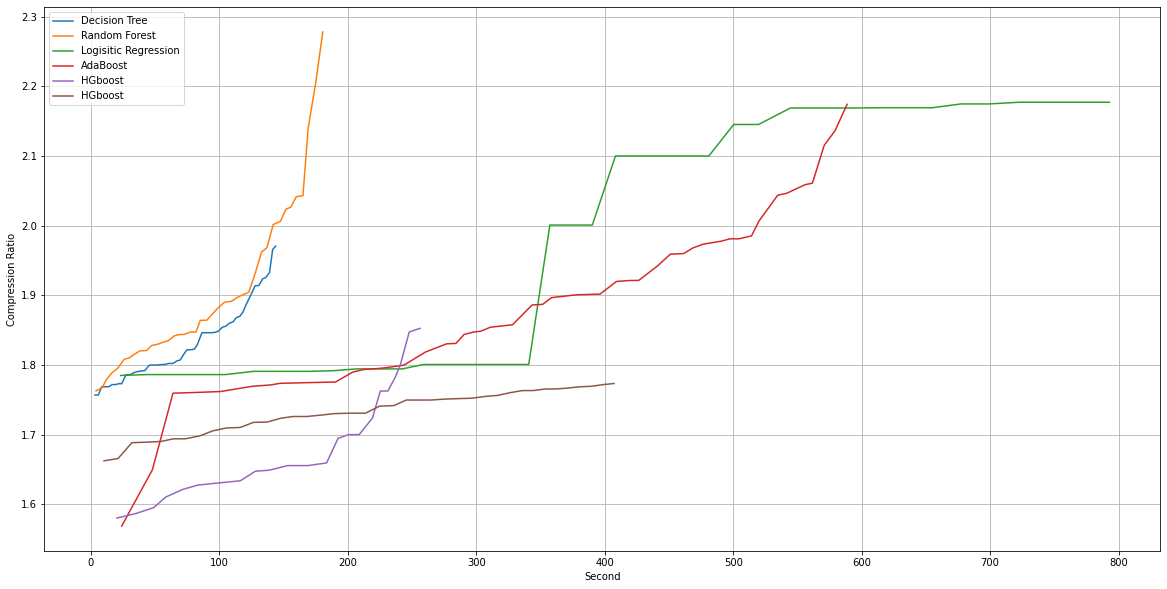

In [55]:
# Your plotting code here, which should use the LOADED search results

plt.figure(figsize=(20,10))
#sorting based on the mean fit time colomn in cv_result_
#Decisio Tree
df = pd.DataFrame(decision_tree.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']].sort_values(by ='rank_test_score', ascending=False)
df['cum'] = df['mean_fit_time'].cumsum()
plt.plot(df['cum'], df['mean_test_score'], label = 'Decision Tree')
#Random Forest
df1 = pd.DataFrame(random_forest.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']].sort_values(by ='rank_test_score', ascending=False)
df1['cum'] = df1['mean_fit_time'].cumsum()
plt.plot(df1['cum'], df1['mean_test_score'], label = 'Random Forest')
#Logistic Regression
df2 = pd.DataFrame(logistic_regression.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']].sort_values(by ='rank_test_score', ascending=False)
df2['cum'] = df2['mean_fit_time'].cumsum()
plt.plot(df2['cum'], df2['mean_test_score'], label = 'Logisitic Regression')
#Aboost
df3 = pd.DataFrame(Aboost.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']].sort_values(by ='rank_test_score', ascending=False)
df3['cum'] = df3['mean_fit_time'].cumsum()
plt.plot(df3['cum'], df3['mean_test_score'], label = 'AdaBoost')
#HGboost
df4 = pd.DataFrame(HGboost.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']].sort_values(by ='rank_test_score', ascending=False)
df4['cum'] = df4['mean_fit_time'].cumsum()
plt.plot(df4['cum'], df4['mean_test_score'], label = 'HGboost')
#SVM
df5 = pd.DataFrame(SVM.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']].sort_values(by ='rank_test_score', ascending=False)
df5['cum'] = df5['mean_fit_time'].cumsum()
plt.plot(df5['cum'], df5['mean_test_score'], label = 'HGboost')


plt.ylabel('Compression Ratio')
plt.xlabel('Second')
plt.legend()
plt.grid(True)

**Question.** Based on *YOUR* plot:
* If the "short race" was a 5 minute compute budget, which classifier(s) would win?
* If the "long race" was the longest budget you trained for, which classifier(s) would win?

For a short race random forest.
For a long race logistic regression.

**Print the compression ratios on training and testing data.** Use the pipeline that had best cross-validation compression ratio for each type of classifier. Also print the total time it took to score each pipeline. Your output should look something like this:
```
dummy: trn=?.???? tst=?.???? time=?.??? sec
dtree: trn=?.???? tst=?.???? time=?.??? sec
rf:    trn=?.???? tst=?.???? time=?.??? sec
lr:    trn=?.???? tst=?.???? time=?.??? sec
ab:    trn=?.???? tst=?.???? time=?.??? sec
hgb:   trn=?.???? tst=?.???? time=?.??? sec
svm:   trn=?.???? tst=?.???? time=?.??? sec
```

In [46]:
from sklearn.pipeline import Pipeline
#fitting pipeline for the dummy classifier 
re1 = RankEncoder(extractor=ExtractContext(size=3),
                 estimator=sklearn.dummy.DummyClassifier(random_state=0))

huff1 = HuffmanEncoder(alphabet = ALPHABET)

compress1 = sklearn.pipeline.Pipeline([('RankEncoder', re1),('HuffmanEncoder', huff1)])
compress1.fit_transform(train)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


[b'\x7fm~4\x03\x15+\x13\xafLl\xd2\x94h\x8bJ\xbd\xd8\xa3\x04\x89\xf1\xbb\x80D\x85)\xc5B\xf3\xd8$E\x82\x13\xc8\xe0\xea\xab{\xc4\xed\x97\x88\x04\xa8Y\xbe\x15\xd3n\t\xf3t\xf1\xd8\x1eVf\xec\xafab\xa1\x9bEU\xe1P\x0c-E\xda\xf0\xc8\x19\x1a\xe6\xd8L\xd66\xbb \xd9\xf79-R\x9f\xb3\x84\xb9\xc0\xbd\xb6-\xff\x95g\xef\xde?\xeeq`GL\'\xa6;\x05\xf4mM*\x15=\x91\x94\xff*\x06\xde\xcbSed\xb1vp\x96\xdb^\x0c\xdf\xab\xe2}\x04-8\xeb\xc5R\xee\xc5\n6\x0f\x90\xdb\xb0\t\xabR\xa9\xd8\x95x\xacM\xd6\x1dS\xd8W\xa4\xfb`\xb1\xd9\xcb8\xc9\x1a\xbeT!;~X.(\xce\x99\xc8\xe0\xc4\xac\xb2f\xb1J\xb3,\x18O\xce\x9e^zU\x0cT?\x11\xb8\xa8f\xad\xee\xcb\xd9g\x88,T,O+,\xa6\xed\xa1TVL\x8e\x13\xbc\xeb\xe2D\xb6\xd4\xd5\x94\x90\xa7\xed\xccv\xe1\xc2\xc6\xd4\x0c\xb1\xb4q\xc382\xa4kR\xaa\xde\'\x81j8L\x07\xa0ks\x1cH\xe9h\xaaFI\xbd\x81S\xc85\x1c[\x00X\x8b\xb13\xaf\x06p\xaa\xff:e\x16<u\x9fcs\x83\x17b\x91\xd4\xb7\x10$\xe1Li\xc0\xb5\x9c\xb3\x8c\xbd\x17\xe5&!\xe11\xc5\x85"\xc4\xb3#\x0c{F\xd8t\tbv\xf9\xbaS\x87\x82sn4\xbe\t\x83\x95[\x8e\xc9b\xd6N\xa3j\x8

In [59]:
# Your code here
print('dummy: trn=%f tst=%f' %(compress1.score(train), compress1.score(test)))
print('dtree: trn=%f tst=%f time=%.1f' %(decision_tree.best_estimator_.score(train), decision_tree.best_estimator_.score(test), decision_tree.refit_time_))
print('rf:    trn=%f tst=%f time=%.1f' %(random_forest.best_estimator_.score(train), random_forest.best_estimator_.score(test), random_forest.refit_time_))
print('lr:    trn=%f tst=%f time=%.1f' %(logistic_regression.best_estimator_.score(train), logistic_regression.best_estimator_.score(test), logistic_regression.refit_time_))
print('ab:    trn=%f tst=%f time=%.1f' %(Aboost.best_estimator_.score(train), Aboost.best_estimator_.score(test), Aboost.refit_time_))
print('hgb:   trn=%f tst=%f time=%.1f' %(HGboost.best_estimator_.score(train),HGboost.best_estimator_.score(test), HGboost.refit_time_))
print('svm:   trn=%f tst=%f time=%.1f' %(SVM.best_estimator_.score(train) ,SVM.best_estimator_.score(test), SVM.refit_time_))

dummy: trn=1.609528 tst=1.609788
dtree: trn=2.107778 tst=1.931807 time=1.8
rf:    trn=3.343363 tst=2.334267 time=4.8
lr:    trn=3.394049 tst=2.240394 time=20.0
ab:    trn=3.601873 tst=2.259632 time=8.6
hgb:   trn=1.962452 tst=1.840773 time=7.6
svm:   trn=1.765537 tst=1.748557 time=10.6


**Question.** 
* Which classifier do you think would be most useful in a real command-line compression tool? Why?
* Which classifier would be the least useful in a command-line compression tool? Why?

Your answer here.

The least favourite can be the dummy classifier. Because it just predict based on most frequent alphabet in the text and it does not help.

The most favourite can be ADaboost, however it has long training time but Since it uses boosting method, it can help to predict the next symbol better and compress the text really better.

My answers are based on the test performance.


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q5 (BONUS) &mdash; Compress MORE!!! [5 marks]

<table><tr><td><img src="img/more1.png" width=300/></td><td><img src="img/more2.png" width=300/></td></tr></table>

Up until now you've used relatively small training sets, involving only a handful of (truncated) files. You probably also found that the best hyperparameters do not use of very much "context", and so the predictions are primitive.

For this bonus question, you should **"go all out" maximizing the compression ratio**, even more than you did so in Q4. 

Specifically, here are the requirements:
1. **Python packages.** You cannot rely on new Python packages. Only scikit-learn and its dependencies. 
2. **Training data.** You can train on any Python file from the scikit-learn 0.24.1 source code. (It is too large to train on all of it, so choose some files.)
3. **Estimators.** You can only use built-in scikit-learn estimators, alone or in combination. You *can* use estimators that were not yet convered in the assignment, however.)
4. **New features.** You are encouraged to introduce new hand-engineered features alongside the context features. See [*FeatureUnion*](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) for example. 
5. **Features from classical compression algorithms not allowed.** A caveat to #4: new features should be based on the semantic meaning of symbols or words, like whether previous symbols were digits, or whether the previous symbols were a particular Python syntax elements (keywords, comments, etc), etc. If you instead try to incorporate classical string compression techniques, then you make the machine learning component trivial and that defeats the purpose of the exercise.

**Grading.** Your final tuned compression pipeline should be saved to a file, which the TA will load and run on a separate withheld test set. Your bonus grade will be computed by scaling your rank among all other students who submitted a bonus question. For example, if 23 students completed the bonus question, and your compression ratio was the 3rd-best (21 of 23), then your grade would be 21/23 = 4.57 extra marks.

In [ ]:
# Load your training set here

In [ ]:
# Define your own unique compression pipeline architecture here

In [ ]:
# Perform hyperparameter search on your pipeline architecture here

In [ ]:
#FINAL_SEARCH_FILE == 'yourname-final.joblib'   # <-- Put your name here
# Save your model to FINAL_SEARCH_FILE here. INCLUDE THE FILE WITH YOUR SUBMISSION.

**Edit and run the code cell below** to demonstrate the performance of your final model on your own test set. The TA will replace *FINAL_ZIP* and *FINAL_FILTER* with a withheld test set, not necessarily from scikit-learn's source code.

In [ ]:
# Uncomment these lines and complete them.

# Load a final test set to try compressing
#FINAL_ZIP = ...       # The location of a ZIP from which to load test files
#FINAL_FILTER = ...    # A filename filter; THE TA WILL REPLACE THIS WITH MYSTERY TEST SET
#x_final_names, x_final = read_textfiles(FINAL_ZIP, FINAL_FILTER)

# Load and score the search object that performed the Q5 hyperparameter search.
#search_final = ...            # Load FINAL_SEARCH_FILE
#search_final.score(x_final)   # Return the compression ratio on the test files